In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
from keras.models import *
import matplotlib.pyplot as plt
import networkx as nx
import collections

In [ ]:
import Testing

## Loading and Preprocessing Testing Data

There are 3 testing dataset: `(x_test_pref, y_test_pref)`, `(x_test_bern, y_test_bern)`, `(x_test_sb, y_test_sb)`. Where the `x_test_{}` portion contains the summed sample adjacency matrices genrated from the respective distrbution and `y_test_{}` contains the respective "known" means. Each set contains 900 summed sample adjacency matrices and thier respective "known" means 

In [ ]:
x_test_pref = np.load('Data/xtest_pref.npy')
y_test_pref = np.load('Data/ytest_pref.npy')
sample_mean_spectra_pref = np.load('Data/sample_mean_spectrum_pref.npy')

x_test_bern = np.load('Data/xtest_bern.npy')
y_test_bern = np.load('Data/ytest_bern.npy')
sample_mean_spectra_bern = np.load('Data/sample_mean_spectrum_bern.npy')

x_test_sb = np.load('Data/xtest_sb.npy')
y_test_sb = np.load('Data/ytest_sb.npy')
sample_mean_spectra_sb = np.load('Data/sample_mean_spectrum_sb.npy')

Now we need to normalize the x_test graphs and make both the x_test and y_test (28,28,1) tensors

In [ ]:
x_test_pref = x_test_pref/255
x_test_pref = np.expand_dims(x_test_pref, -1)
y_test_pref = np.expand_dims(y_test_pref, -1)

x_test_bern = x_test_bern/255
x_test_bern = np.expand_dims(x_test_bern, -1)
y_test_bern = np.expand_dims(y_test_bern, -1)

x_test_sb = x_test_sb/255
x_test_sb = np.expand_dims(x_test_sb, -1)
y_test_sb = np.expand_dims(y_test_sb, -1)

## Loading the Trained Models

In [ ]:
ERUnet = load_model('Models/bern28model.h5')
SBMUnet = load_model('Models/sb28model.h5')
PAUnet = load_model('Models/pref28model.h5')
GenUnet = load_model('Models/gen28model.h5')

## Testing on ER Data 

I present a `baseline_model` that will be useful in comparing the results. The base model takes a "simple avegare" of all the entries of a given sample adjacency matrix. For example suppose $X$ is a sample adjacency matrix composed of $N$ adjacency matrices generated from the same distribution, i.e: $$X = \sum_{i=1}^{N}A_{(i)}.$$ If we now assume that each of the $A_{(i)}$ have $n$ nodes then the `baseline_model` returns: $$X^{*} = \frac{1}{N}X$$ where the entries of $X^*$ are rounded to either 0 or 1    

In [ ]:
ERUnet_pred = ERUnet.predict(x_test_bern)
ERUnet_pred = ERUnet_pred.round(decimals=0)
SBMUnet_pred = SBMUnet.predict(x_test_bern)
SBMUnet_pred = SBMUnet_pred.round(decimals=0)
PAUnet_pred = PAUnet.predict(x_test_bern)
PAUnet_pred = PAUnet_pred.round(decimals=0)
GenUnet_pred = GenUnet.predict(x_test_bern)
GenUnet_pred = GenUnet_pred.round(decimals=0)

baseline_pred = Testing.baseline_model(x_test_bern)

Now lets calculate the spectrums for each of the predicted adjacency matrices for each model, the baseline model, and the target: 

From the ``` Testing.py ``` modual I call the spectrum function which calculates and returns the orderd absolute value eigenvalues for each adjacency matrix. i.e if $A_{(i)}$ the adjacency matrix for graph $i$, with $n$ nodes, then ```spectrum``` returns the list $(\lambda_1^{(i)}, \lambda_2^{(i)}, ..., \lambda_n^{(i)})$ where $\lambda_1^{(i)} \geq \lambda_1^{(i)} \geq . . . \geq \lambda_n^{(i)} > 0$ 

In [ ]:
# computing the models:
ERUnet_eigenvals = Testing.spectrum(ERUnet_pred)
SBMUnet_eigenvals = Testing.spectrum(SBMUnet_pred)
PAUnet_eigenvals = Testing.spectrum(PAUnet_pred)
GenUnet_eigenvals = Testing.spectrum(GenUnet_pred)

# baseline 
baseline_eigenvals = Testing.spectrum(baseline_pred, reshape=False, round=False)

#target 
target_eigenvals = Testing.spectrum(y_test_bern)

Now lets comput the spectral diffrence and the percentage spectral difference. for predicted adjacency matrix from each model with the target spectrum as well as the spectral diffrence for the baseline model and the target. 

From the `Testing.py` modual I call the `spectral_diff` function which returns the the absolute diffrence between a predicted eigenvalue and a target spectrum: 

Let $(\lambda_1^{(i)}, \lambda_2^{(i)}, ..., \lambda_n^{(i)})$ be the sprectrum from predicted adjacency matrix $A_{(i)}$ where $\lambda_1^{(i)} \geq \lambda_1^{(i)} \geq . . . \geq \lambda_n^{(i)} > 0$ and let $(\lambda_1^{(t_i)}, \lambda_2^{(t_i)}, ..., \lambda_n^{(t_i)})$ be the spectrum from the target adjacency matrix $A_{(t_i)}$ where $\lambda_1^{(t_i)} \geq \lambda_1^{(t_i)} \geq . . . \geq \lambda_n^{(t_i)} > 0$. Then the `spectral_diff` function returns: 

$$\left(|\lambda_1^{(i)} - \lambda_1^{(t_i)}|, |\lambda_2^{(i)} - \lambda_2^{(t_i)}|, ..., |\lambda_n^{(i)} - \lambda_n^{(t_i)}|\right) = \left(\lambda_1^{(sd_i)},\lambda_2^{(sd_i)}, ..., \lambda_n^{(sd_i)}\right)$$ when the parameter `percent = False`. If `True` returns: 

$$\left(\frac{|\lambda_1^{(i)} - \lambda_1^{(t_i)}|}{|\lambda_1^{(t_i)}|}, \frac{|\lambda_2^{(i)} - \lambda_2^{(t_i)}|}{|\lambda_2^{(t_i)}|}, ..., \frac{|\lambda_n^{(i)} - \lambda_n^{(t_i)}|}{|\lambda_n^{(t_i)}|}\right) = \left(\lambda_1^{(psd_i)},\lambda_2^{(psd_i)}, ..., \lambda_n^{(psd_i)}\right)$$

In [ ]:
ERUnet_specdiff = Testing.spectral_diff(ERUnet_eigenvals, target_eigenvals)
SBMUnet_specdiff = Testing.spectral_diff(SBMUnet_eigenvals, target_eigenvals)
PAUnet_specdiff = Testing.spectral_diff(PAUnet_eigenvals, target_eigenvals)
GenUnet_specdiff = Testing.spectral_diff(GenUnet_eigenvals, target_eigenvals)

baseline_specdiff = Testing.spectral_diff(baseline_eigenvals, target_eigenvals)

ERUnet_percent_specdiff = Testing.spectral_diff(ERUnet_eigenvals, target_eigenvals, percent=True)
SBMUnet_percent_specdiff = Testing.spectral_diff(SBMUnet_eigenvals, target_eigenvals, percent=True)
PAUnet_percent_specdiff = Testing.spectral_diff(PAUnet_eigenvals, target_eigenvals, percent=True)
GenUnet_percent_specdiff = Testing.spectral_diff(GenUnet_eigenvals, target_eigenvals, percent=True)

baseline_percent_specdiff = Testing.spectral_diff(baseline_eigenvals, target_eigenvals, percent=True)

Now lets compute the average loss of each eigenvalue for each model 

From the `Testing.py` modual I call the `average_spectral_diff` function which return the average absolute eigenvalue diffrence for a given spectral diffrence set. 

For example let $\Lambda$ be a set of $s$ spectral diffrences. $$\Lambda = \left[\left(\lambda_1^{(sd_1)},\lambda_2^{(sd_1)}, ..., \lambda_n^{(sd_1)}\right), \left(\lambda_1^{(sd_2)},\lambda_2^{(sd_2)}, ..., \lambda_n^{(sd_2)}\right), ..., \left(\lambda_1^{(sd_s)},\lambda_2^{(sd_s)}, ..., \lambda_n^{(sd_s)}\right)\right]$$ where $\left(\lambda_1^{(sd_i)},\lambda_2^{(sd_i)}, ..., \lambda_n^{(sd_i)}\right)$ are calculated the same way as above. Then the `average_spectral_diff` returns: 

$$\left(\frac{1}{s}\sum_{i=1}^s \lambda_1^{(sd_i)}, \frac{1}{s}\sum_{i=1}^s \lambda_2^{(sd_i)}, ..., \frac{1}{s}\sum_{i=1}^s \lambda_n^{(sd_i)} \right) = \left(\bar{\lambda_1^{sd}}, \bar{\lambda_2^{sd}}, . . ., \bar{\lambda_n^{sd}}\right)$$

In [ ]:
ERUnet_avg_diff = Testing.average_spectral_diff(ERUnet_specdiff)
SBMUnet_avg_diff = Testing.average_spectral_diff(SBMUnet_specdiff)
PAUnet_avg_diff = Testing.average_spectral_diff(PAUnet_specdiff)
GenUnet_avg_diff = Testing.average_spectral_diff(GenUnet_specdiff)

baseline_avg_diff = Testing.average_spectral_diff(baseline_specdiff)

ERUnet_avg_percent_diff = Testing.average_spectral_diff(ERUnet_percent_specdiff)
SBMUnet_avg_percent_diff = Testing.average_spectral_diff(SBMUnet_percent_specdiff)
PAUnet_avg_percent_diff = Testing.average_spectral_diff(PAUnet_percent_specdiff)
GenUnet_avg_percent_diff = Testing.average_spectral_diff(GenUnet_percent_specdiff)

baseline_avg_percent_diff = Testing.average_spectral_diff(baseline_percent_specdiff)

### Plotting on ER Data 

Now lets plot the average absolute loss per Eigenvalue 

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 28})

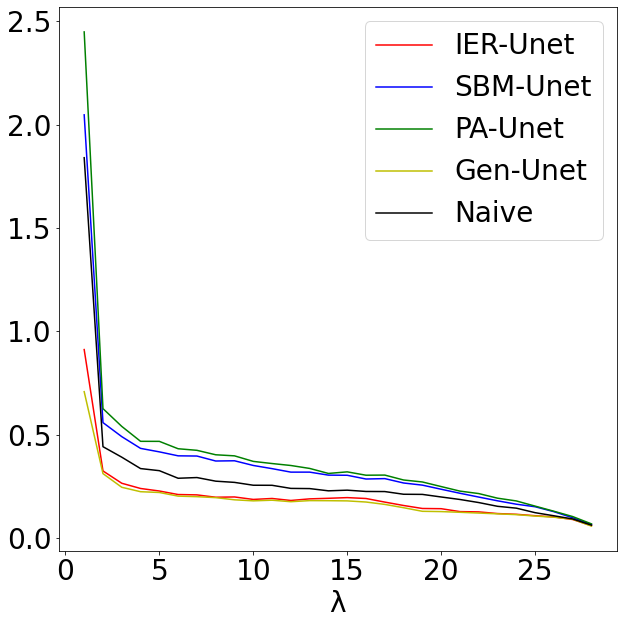

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
k = np.arange(1, len(ERUnet_specdiff[0])+1,1)
plt.plot(k, ERUnet_avg_diff,'r') 
plt.plot(k, SBMUnet_avg_diff,'b') 
plt.plot(k, PAUnet_avg_diff,'g') 
plt.plot(k, GenUnet_avg_diff,'y') 
plt.plot(k, baseline_avg_diff,'k') 
plt.legend(["IER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Naive"])
plt.xlabel(chr(955))
plt.savefig('ER-AADE.pdf')

Text(0.5, 0, 'λ')

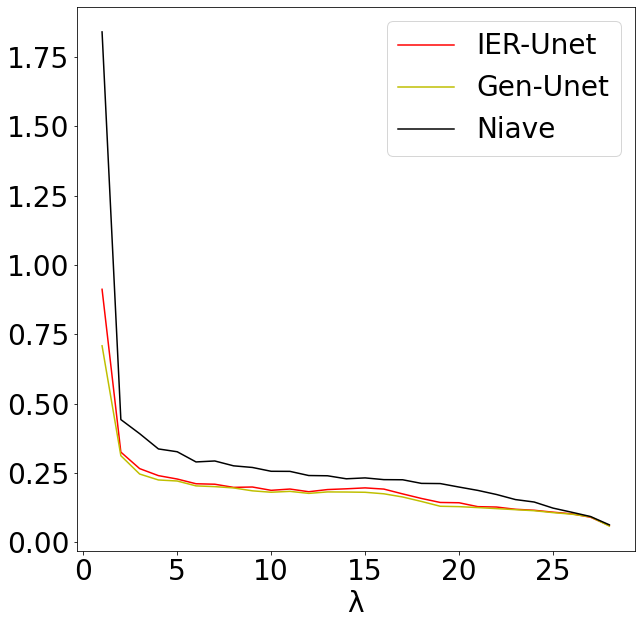

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(k, ERUnet_avg_diff,'r') 
plt.plot(k, GenUnet_avg_diff,'y') 
plt.plot(k, baseline_avg_diff,'k') 
plt.legend(["IER-Unet", "Gen-Unet", "Niave"])
plt.xlabel(chr(955))

In [ ]:
import pandas as pd

In [ ]:
temp = list(zip(k, ERUnet_avg_diff, SBMUnet_avg_diff, PAUnet_avg_diff, GenUnet_avg_diff, baseline_avg_diff))
colnames = [chr(955), 'ER-Unet', 'SBM-Unet', 'PA-Unet', 'Gen-Unet', 'Baseline']
AvgAbsLoss = pd.DataFrame(temp, columns = colnames)

In [ ]:
for col in AvgAbsLoss.columns:
  print(col)
  print(max(AvgAbsLoss[col]))
  print(AvgAbsLoss[col].idxmax()+1)
  print("-------------------")

λ
28
28
-------------------
ER-Unet
0.912596635428269
1
-------------------
SBM-Unet
2.0482457317103164
1
-------------------
PA-Unet
2.449364506721747
1
-------------------
Gen-Unet
0.7088727495951858
1
-------------------
Baseline
1.84088089264743
1
-------------------


In [ ]:
for col in AvgAbsLoss.columns:
  print(col)
  print(min(AvgAbsLoss[col]))
  print(AvgAbsLoss[col].idxmin()+1)
  print("-------------------")

λ
1
1
-------------------
ER-Unet
0.060550111187589975
28
-------------------
SBM-Unet
0.06647190601211157
28
-------------------
PA-Unet
0.06932767562717897
28
-------------------
Gen-Unet
0.05860495110173515
28
-------------------
Baseline
0.06317345655660538
28
-------------------


In [ ]:
AvgAbsLoss

,λ,ER-Unet,SBM-Unet,PA-Unet,Gen-Unet,Baseline
0,1,0.912597,2.048246,2.449365,0.708873,1.840881
1,2,0.325435,0.559281,0.626889,0.312456,0.442748
2,3,0.265864,0.491387,0.540880,0.246378,0.391972
3,4,0.240576,0.434565,0.468706,0.224944,0.336854
4,5,0.228337,0.417694,0.468496,0.221182,0.326707
5,6,0.211310,0.398514,0.432794,0.203565,0.289997
6,7,0.209580,0.397521,0.425176,0.200883,0.293441
7,8,0.198214,0.373424,0.403622,0.196254,0.275933
8,9,0.199557,0.374566,0.398450,0.185770,0.270066
9,10,0.187599,0.351905,0.371603,0.180678,0.256270


Now lets look at percentage loss

Text(0.5, 0, 'λ')

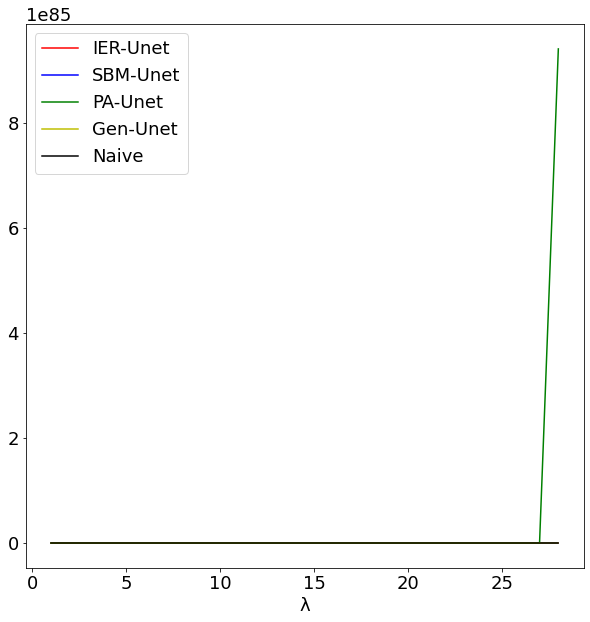

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
k = np.arange(1, len(ERUnet_percent_specdiff[0])+1,1)
plt.plot(k, ERUnet_avg_percent_diff,'r') 
plt.plot(k, SBMUnet_avg_percent_diff,'b') 
plt.plot(k, PAUnet_avg_percent_diff,'g') 
plt.plot(k, GenUnet_avg_percent_diff,'y') 
plt.plot(k, baseline_avg_percent_diff,'k') 
plt.legend(["IER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Naive"])
plt.xlabel(chr(955))

In [ ]:
k[25:28]

array([26, 27, 28])

In [ ]:
ERUnet_eigenvals[3]

array([-4.0356021e+00, -3.6658673e+00, -3.0127501e+00, -2.6007919e+00,
       -2.3638132e+00, -2.2012002e+00, -1.8066833e+00, -1.5164999e+00,
       -1.3304646e+00, -1.1656512e+00, -7.3855460e-01, -5.7285374e-01,
       -4.7659627e-01, -7.5876914e-02, -3.8857806e-16,  5.8033567e-02,
        6.1403143e-01,  7.8859890e-01,  1.0949416e+00,  1.2408440e+00,
        1.6104091e+00,  1.7539738e+00,  1.8616614e+00,  2.1110954e+00,
        2.5890384e+00,  2.6942177e+00,  3.3323610e+00,  5.8139992e+00],
      dtype=float32)

In [ ]:
target_eigenvals[3]

array([-3.89116652, -3.40609916, -3.27169305, -2.58921155, -1.93051006,
       -1.75035753, -1.50687351, -1.34923841, -1.19236743, -1.01663822,
       -0.84183232, -0.51884672, -0.4773297 , -0.26446002,  0.02783151,
        0.42126605,  0.6063881 ,  0.6846144 ,  0.80966827,  1.09441342,
        1.46182371,  1.59398927,  1.80294545,  2.28555844,  2.33515756,
        2.48142028,  3.12533183,  5.27621591])

Text(0.5, 0, 'λ')

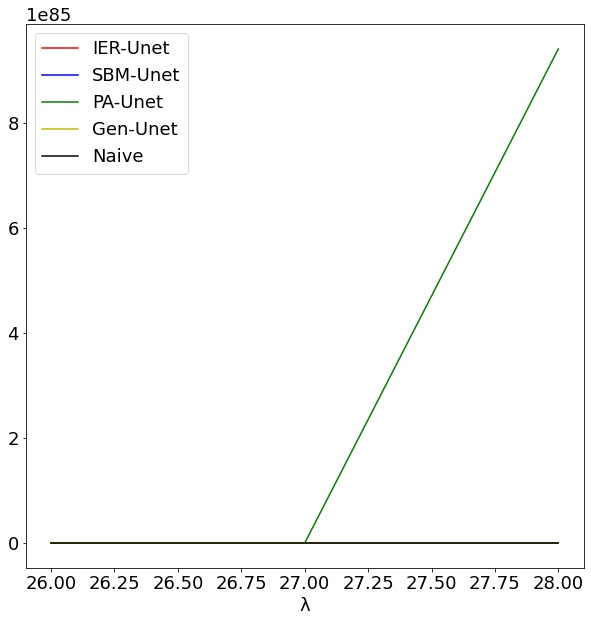

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
k = np.arange(1, len(ERUnet_percent_specdiff[0])+1,1)
plt.plot(k[25:28], ERUnet_avg_percent_diff[25:28],'r') 
plt.plot(k[25:28], SBMUnet_avg_percent_diff[25:28],'b') 
plt.plot(k[25:28], PAUnet_avg_percent_diff[25:28],'g') 
plt.plot(k[25:28], GenUnet_avg_percent_diff[25:28],'y') 
plt.plot(k[25:28], baseline_avg_percent_diff[25:28],'k') 
plt.legend(["IER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Naive"])
plt.xlabel(chr(955))

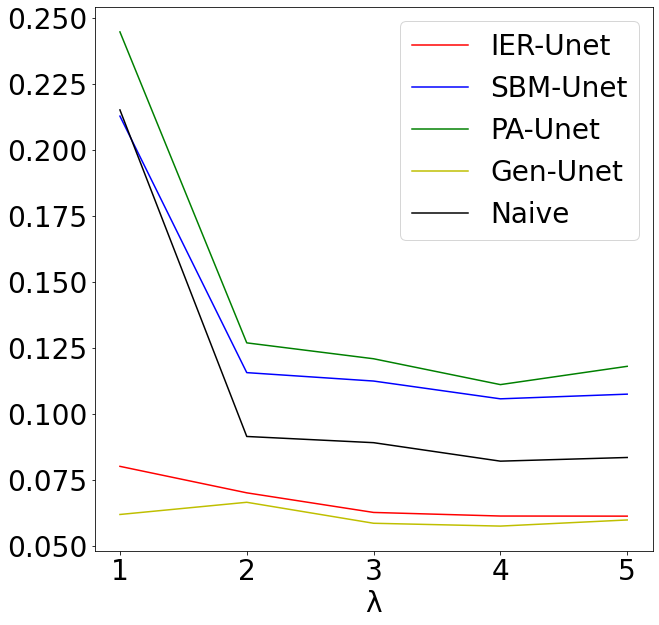

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
k = np.arange(1, len(ERUnet_percent_specdiff[0])+1,1)
plt.plot(k[0:5], ERUnet_avg_percent_diff[0:5],'r') 
plt.plot(k[0:5], SBMUnet_avg_percent_diff[0:5],'b') 
plt.plot(k[0:5], PAUnet_avg_percent_diff[0:5],'g') 
plt.plot(k[0:5], GenUnet_avg_percent_diff[0:5],'y') 
plt.plot(k[0:5], baseline_avg_percent_diff[0:5],'k') 
plt.legend(["IER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Naive"])
plt.xlabel(chr(955))
plt.savefig('ER-AAPDE.pdf')

In [ ]:
temp = list(zip(k, ERUnet_avg_percent_diff, SBMUnet_avg_percent_diff, 
                PAUnet_avg_percent_diff, GenUnet_avg_percent_diff, baseline_avg_percent_diff))
colnames = [chr(955), 'ER-Unet', 'SBM-Unet', 'PA-Unet', 'Gen-Unet', 'Baseline']
AvgPctLoss = pd.DataFrame(temp, columns = colnames)

In [ ]:
for col in AvgPctLoss.columns:
  print(col)
  print(max(AvgPctLoss[col]))
  print(AvgPctLoss[col].idxmax()+1)
  print("-------------------")

λ
28
28
-------------------
ER-Unet
1.6629099057310417e+63
27
-------------------
SBM-Unet
2.519576272199308e+77
27
-------------------
PA-Unet
9.400402467481317e+85
28
-------------------
Gen-Unet
4.368040008800221e+29
24
-------------------
Baseline
2.7159130727288793e+70
28
-------------------


In [ ]:
for col in AvgPctLoss.columns:
  print(col)
  print(min(AvgPctLoss[col]))
  print(AvgPctLoss[col].idxmin()+1)
  print("-------------------")

λ
1
1
-------------------
ER-Unet
0.06058690440912395
6
-------------------
SBM-Unet
0.1056189169723692
4
-------------------
PA-Unet
0.11100584526005643
4
-------------------
Gen-Unet
0.05739716522264409
4
-------------------
Baseline
0.07807473722774091
6
-------------------


In [ ]:
AvgPctLoss[0:10]['Baseline']

0    0.215085
1    0.091355
2    0.089005
3    0.081999
4    0.083392
5    0.078075
6    0.084015
7    0.086198
8    0.090945
9    0.092882
Name: Baseline, dtype: float64

In [ ]:
max(AvgPctLoss[0:10]['Baseline'])

0.21508486593927895

Now lets look at some actual graphs 

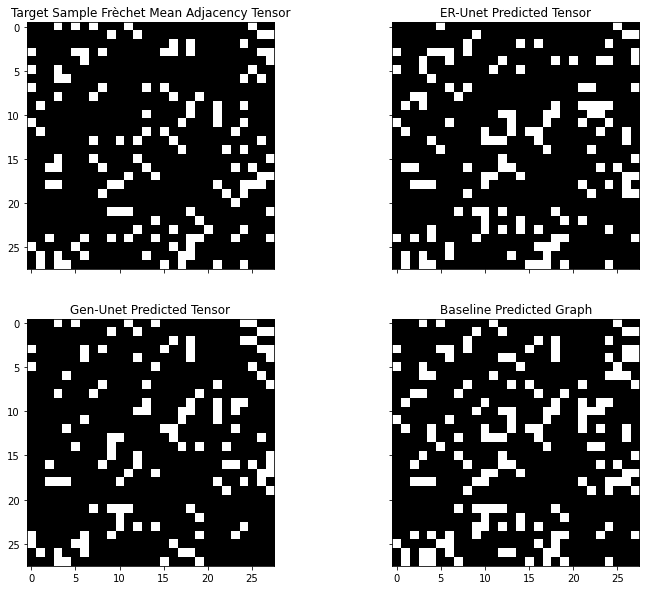

In [ ]:
plt.rcParams['figure.figsize'] = [12, 10]
fig, axs = plt.subplots(2, 2)

axs[0,0].imshow(y_test_bern[3].reshape((28,28)), cmap=plt.get_cmap('gray'))
axs[0,0].set_title('Target Sample Frèchet Mean Adjacency Tensor')

axs[0,1].imshow(ERUnet_pred[3].reshape((28,28)), cmap=plt.get_cmap('gray'))
axs[0,1].set_title('ER-Unet Predicted Tensor')

axs[1,0].imshow(GenUnet_pred[3].reshape((28,28)), cmap=plt.get_cmap('gray'))
axs[1,0].set_title('Gen-Unet Predicted Tensor')

axs[1,1].imshow(baseline_pred[3], cmap=plt.get_cmap('gray'))
axs[1,1].set_title('Baseline Predicted Graph')

for ax in axs.flat:
  ax.label_outer()

Text(0.5, 0, 'λ')

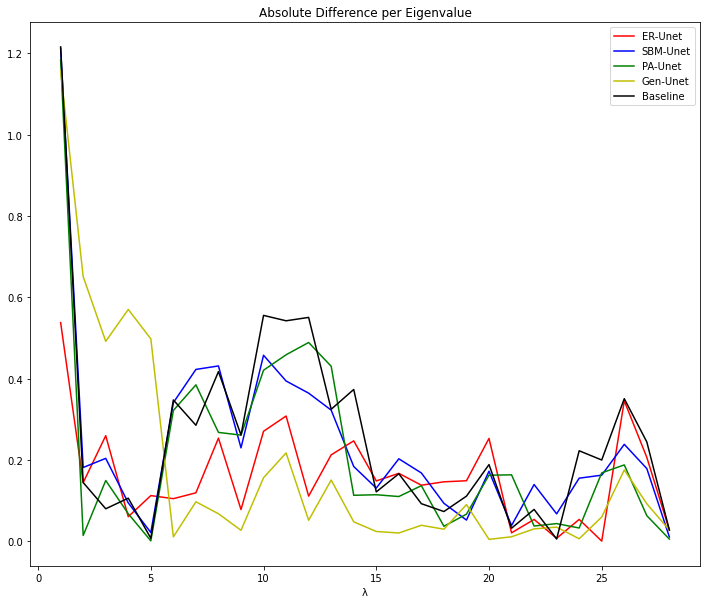

In [ ]:
plt.rcParams['figure.figsize'] = [12, 10]
k = np.arange(1, len(ERUnet_specdiff[0])+1,1)
plt.plot(k, ERUnet_specdiff[3],'r') 
plt.plot(k, SBMUnet_specdiff[3],'b') 
plt.plot(k, PAUnet_specdiff[3],'g') 
plt.plot(k, GenUnet_specdiff[3],'y') 
plt.plot(k, baseline_specdiff[3],'k') 
plt.legend(["ER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Baseline"])
plt.title('Absolute Difference per Eigenvalue')
plt.xlabel(chr(955))

Text(0.5, 0, 'λ')

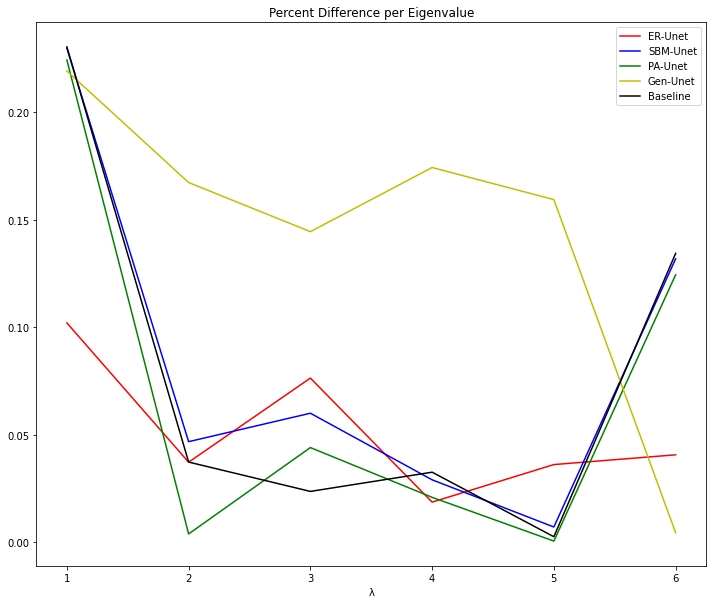

In [ ]:
plt.rcParams['figure.figsize'] = [12, 10]
k = np.arange(1, len(ERUnet_specdiff[0])+1,1)
plt.plot(k[0:6], ERUnet_percent_specdiff[3][0:6],'r') 
plt.plot(k[0:6], SBMUnet_percent_specdiff[3][0:6],'b') 
plt.plot(k[0:6], PAUnet_percent_specdiff[3][0:6],'g') 
plt.plot(k[0:6], GenUnet_percent_specdiff[3][0:6],'y') 
plt.plot(k[0:6], baseline_percent_specdiff[3][0:6],'k') 
plt.legend(["ER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Baseline"])
plt.title('Percent Difference per Eigenvalue')
plt.xlabel(chr(955))

### Sample Mean Spectra Comparision 

In [ ]:
len(sample_mean_spectra_bern)

900

In [ ]:
ERUNet_Sms_diff_bern = Testing.spectral_diff(ERUnet_eigenvals, sample_mean_spectra_bern)
SBMUNet_Sms_diff_bern = Testing.spectral_diff(SBMUnet_eigenvals, sample_mean_spectra_bern)
PAUNet_Sms_diff_bern = Testing.spectral_diff(PAUnet_eigenvals, sample_mean_spectra_bern)
GenUNet_Sms_diff_bern = Testing.spectral_diff(GenUnet_eigenvals, sample_mean_spectra_bern)

baseline_Sms_diff_bern = Testing.spectral_diff(baseline_eigenvals, sample_mean_spectra_bern)

ERUNet_Sms_perdiff_bern = Testing.spectral_diff(ERUnet_eigenvals, sample_mean_spectra_bern, percent=True)
SBMUNet_Sms_perdiff_bern = Testing.spectral_diff(SBMUnet_eigenvals, sample_mean_spectra_bern, percent=True)
PAUNet_Sms_perdiff_bern = Testing.spectral_diff(PAUnet_eigenvals, sample_mean_spectra_bern, percent=True)
GenUNet_Sms_perdiff_bern = Testing.spectral_diff(GenUnet_eigenvals, sample_mean_spectra_bern, percent=True)

baseline_Sms_perdiff_bern = Testing.spectral_diff(baseline_eigenvals, sample_mean_spectra_bern, percent=True)

In [ ]:
ERUNet_AvgSms_diff_bern = Testing.average_spectral_diff(ERUNet_Sms_diff_bern)
SBMUNet_AvgSms_diff_bern = Testing.average_spectral_diff(SBMUNet_Sms_diff_bern)
PAUNet_AvgSms_diff_bern = Testing.average_spectral_diff(PAUNet_Sms_diff_bern)
GenUNet_AvgSms_diff_bern = Testing.average_spectral_diff(GenUNet_Sms_diff_bern)

baseline_AvgSms_diff_bern = Testing.average_spectral_diff(baseline_Sms_diff_bern)

ERUNet_AvgSms_perdiff_bern = Testing.average_spectral_diff(ERUNet_Sms_perdiff_bern)
SBMUNet_AvgSms_perdiff_bern = Testing.average_spectral_diff(SBMUNet_Sms_perdiff_bern)
PAUNet_AvgSms_perdiff_bern = Testing.average_spectral_diff(PAUNet_Sms_perdiff_bern)
GenUNet_AvgSms_perdiff_bern = Testing.average_spectral_diff(GenUNet_Sms_perdiff_bern)

baseline_AvgSms_perdiff_bern = Testing.average_spectral_diff(baseline_Sms_perdiff_bern)

Text(0.5, 0, 'λ')

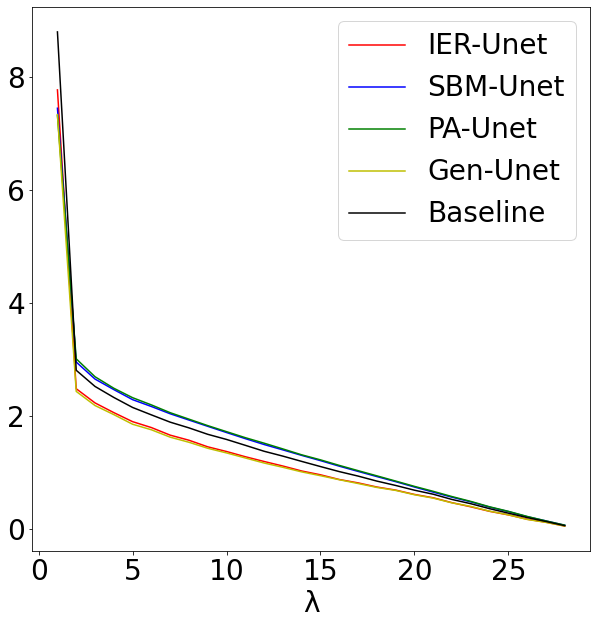

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
k = np.arange(1, len(ERUNet_AvgSms_diff_bern)+1,1)
plt.plot(k, ERUNet_AvgSms_diff_bern,'r') 
plt.plot(k, SBMUNet_AvgSms_diff_bern,'b') 
plt.plot(k, PAUNet_AvgSms_diff_bern,'g') 
plt.plot(k, GenUNet_AvgSms_diff_bern,'y') 
plt.plot(k, baseline_AvgSms_diff_bern,'k') 
plt.legend(["IER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Baseline"])
plt.xlabel(chr(955))

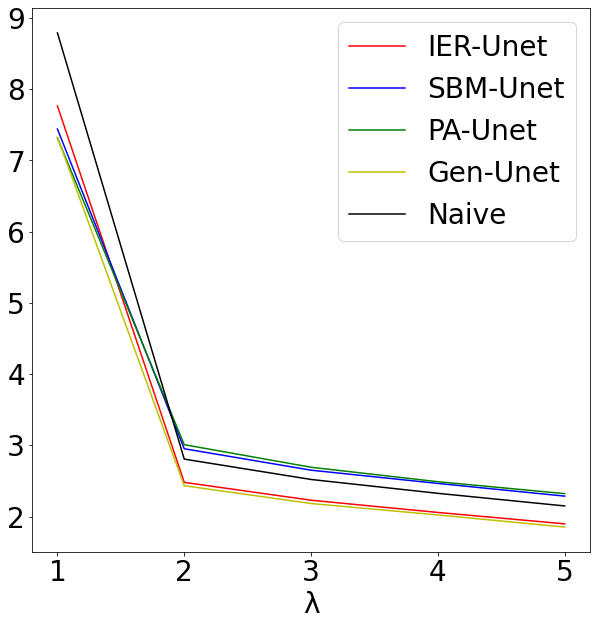

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
k = np.arange(1, len(ERUNet_AvgSms_diff_bern)+1,1)
plt.plot(k[0:5], ERUNet_AvgSms_diff_bern[0:5],'r') 
plt.plot(k[0:5], SBMUNet_AvgSms_diff_bern[0:5],'b') 
plt.plot(k[0:5], PAUNet_AvgSms_diff_bern[0:5],'g') 
plt.plot(k[0:5], GenUNet_AvgSms_diff_bern[0:5],'y') 
plt.plot(k[0:5], baseline_AvgSms_diff_bern[0:5],'k') 
plt.legend(["IER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Naive"])
#plt.title('Average Absolute Difference per Eigenvalue Between Sample Mean Spectrum & Predicted - Erdös-Rényi Testing Data')
plt.xlabel(chr(955))
plt.savefig('AVG-SMS-ER.pdf')

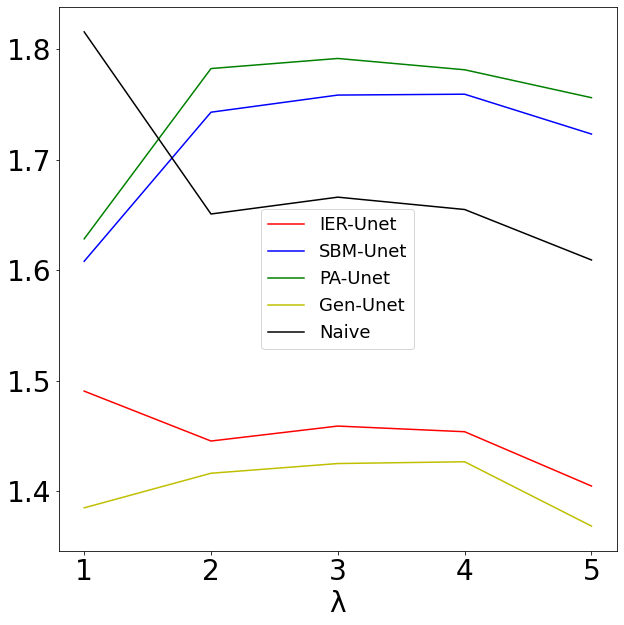

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
k = [1,2,3,4,5]
plt.xticks(k)
plt.plot(k, ERUNet_AvgSms_perdiff_bern[0:5],'r') 
plt.plot(k, SBMUNet_AvgSms_perdiff_bern[0:5],'b') 
plt.plot(k, PAUNet_AvgSms_perdiff_bern[0:5],'g') 
plt.plot(k, GenUNet_AvgSms_perdiff_bern[0:5],'y') 
plt.plot(k, baseline_AvgSms_perdiff_bern[0:5],'k') 
plt.rcParams.update({'font.size': 18})
#plt.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend(["IER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Naive"])
#plt.title('Average Absolute Percent Difference per Eigenvalue Between Sample Mean Spectrum & Predicted - Erdös-Rényi Testing Data')
plt.xlabel(chr(955))
plt.savefig('AVG-SMS-PCT-ER.pdf')

In [ ]:
k

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

### Degree Distributions 

In [ ]:
ytest_degree, ytest_cnt, ytest_pk = Testing.degree_dist(y_test_bern)
ERUnet_pred_degree, ERUnet_pred_cnt, ERUnet_pred_pk = Testing.degree_dist(ERUnet_pred)
GenUnet_pred_degree, GenUnet_pred_cnt, GenUnet_pred_pk = Testing.degree_dist(GenUnet_pred)
SBMUnet_pred_degree, SBMUnet_pred_cnt, SBM_pred_pk = Testing.degree_dist(SBMUnet_pred)
PAUnet_pred_degree, PAUnet_pred_cnt, PAUnet_pred_pk = Testing.degree_dist(PAUnet_pred)
baseline_pred_degree, baseline_pred_cnt, baseline_pred_pk = Testing.degree_dist(baseline_pred, reshape=False, round=False)

In [ ]:
ER_AdKL, ER_targetCounts, ER_predCounts, ER_degrees = Testing.AdjustedKL(ytest_degree, ytest_cnt, ERUnet_pred_degree, ERUnet_pred_cnt)
Gen_AdKL, Gen_targetCounts, Gen_predCounts, Gen_degrees = Testing.AdjustedKL(ytest_degree, ytest_cnt, GenUnet_pred_degree, GenUnet_pred_cnt)
SBM_AdKL, SBM_targetCounts, SBM_predCounts, SBM_degrees = Testing.AdjustedKL(ytest_degree, ytest_cnt, SBMUnet_pred_degree, SBMUnet_pred_cnt)
PA_AdKL, PA_targetCounts, PA_predCounts, PA_degrees = Testing.AdjustedKL(ytest_degree, ytest_cnt, PAUnet_pred_degree, PAUnet_pred_cnt)
baseline_AdKL, baseline_targetCounts, baseline_predCounts, baseline_degrees = Testing.AdjustedKL(ytest_degree, ytest_cnt, baseline_pred_degree, baseline_pred_cnt)

In [ ]:
print(np.mean(ER_AdKL))
print(np.mean(SBM_AdKL))
print(np.mean(PA_AdKL)) 
print(np.mean(Gen_AdKL)) 
print(np.mean(baseline_AdKL))

0.6065889612276055
0.9587764983970614
0.9897980787179946
0.41329853387144433
0.46100270909431373


In [ ]:
print(np.var(ER_AdKL))
print(np.var(SBM_AdKL)) 
print(np.var(PA_AdKL)) 
print(np.var(Gen_AdKL)) 
print(np.var(baseline_AdKL))

0.07377068922653479
0.27718387021422625
0.32249198885313124
0.048772091921411964
0.06745993141957421


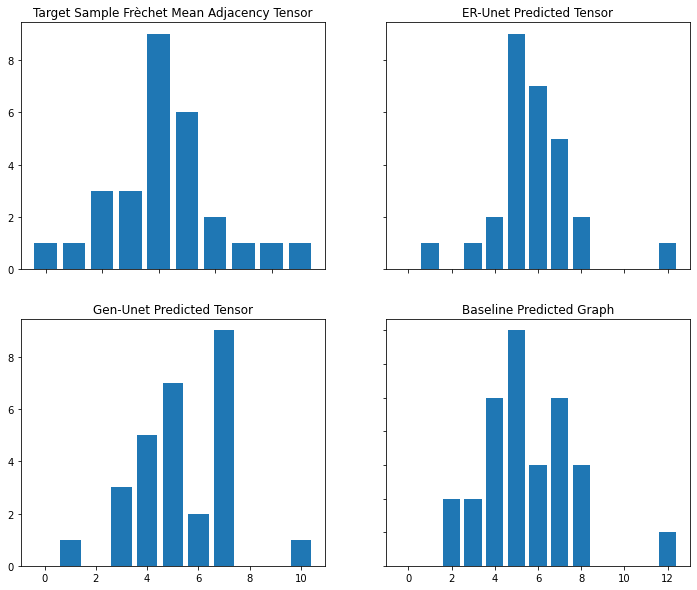

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 10]
fig, axs = plt.subplots(2, 2)

axs[0,0].bar(ytest_degree[2], ytest_cnt[2])
axs[0,0].set_title('Target Sample Frèchet Mean Adjacency Tensor')

axs[0,1].bar(ER_degrees[2], ER_predCounts[2])
axs[0,1].set_title('ER-Unet Predicted Tensor')

axs[1,0].bar(Gen_degrees[2], Gen_predCounts[2])
axs[1,0].set_title('Gen-Unet Predicted Tensor')

axs[1,1].bar(baseline_degrees[2], baseline_predCounts[2])
axs[1,1].set_title('Baseline Predicted Graph')

for ax in axs.flat:
  ax.label_outer()


## Testing on Stochastic Block Data 

### Loading the Data, Predicting, and Generating the Spectrum Info 

In [ ]:
ERUnet_pred_sb = ERUnet.predict(x_test_sb)
ERUnet_pred_sb = ERUnet_pred_sb.round(decimals=0)
SBMUnet_pred_sb = SBMUnet.predict(x_test_sb)
SBMUnet_pred_sb = SBMUnet_pred_sb.round(decimals=0)
PAUnet_pred_sb = PAUnet.predict(x_test_sb)
PAUnet_pred_sb = PAUnet_pred_sb.round(decimals=0)
GenUnet_pred_sb = GenUnet.predict(x_test_sb)
GenUnet_pred_sb = GenUnet_pred_sb.round(decimals=0)

baseline_pred_sb = Testing.baseline_model(x_test_sb)

In [ ]:
# computing the models:
ERUnet_eigenvals_sb = Testing.spectrum(ERUnet_pred_sb)
SBMUnet_eigenvals_sb = Testing.spectrum(SBMUnet_pred_sb)
PAUnet_eigenvals_sb = Testing.spectrum(PAUnet_pred_sb)
GenUnet_eigenvals_sb = Testing.spectrum(GenUnet_pred_sb)

# baseline 
baseline_eigenvals_sb = Testing.spectrum(baseline_pred_sb, reshape=False, round=False)

#target 
target_eigenvals_sb = Testing.spectrum(y_test_sb)

In [ ]:
ERUnet_specdiff_sb = Testing.spectral_diff(ERUnet_eigenvals_sb, target_eigenvals_sb)
SBMUnet_specdiff_sb = Testing.spectral_diff(SBMUnet_eigenvals_sb, target_eigenvals_sb)
PAUnet_specdiff_sb = Testing.spectral_diff(PAUnet_eigenvals_sb, target_eigenvals_sb)
GenUnet_specdiff_sb = Testing.spectral_diff(GenUnet_eigenvals_sb, target_eigenvals_sb)

baseline_specdiff_sb = Testing.spectral_diff(baseline_eigenvals_sb, target_eigenvals_sb)

ERUnet_percent_specdiff_sb = Testing.spectral_diff(ERUnet_eigenvals_sb, target_eigenvals_sb, percent=True)
SBMUnet_percent_specdiff_sb = Testing.spectral_diff(SBMUnet_eigenvals_sb, target_eigenvals_sb, percent=True)
PAUnet_percent_specdiff_sb = Testing.spectral_diff(PAUnet_eigenvals_sb, target_eigenvals_sb, percent=True)
GenUnet_percent_specdiff_sb = Testing.spectral_diff(GenUnet_eigenvals_sb, target_eigenvals_sb, percent=True)

baseline_percent_specdiff_sb = Testing.spectral_diff(baseline_eigenvals_sb, target_eigenvals_sb, percent=True)

In [ ]:
ERUnet_avg_diff_sb = Testing.average_spectral_diff(ERUnet_specdiff_sb)
SBMUnet_avg_diff_sb = Testing.average_spectral_diff(SBMUnet_specdiff_sb)
PAUnet_avg_diff_sb = Testing.average_spectral_diff(PAUnet_specdiff_sb)
GenUnet_avg_diff_sb = Testing.average_spectral_diff(GenUnet_specdiff_sb)

baseline_avg_diff_sb = Testing.average_spectral_diff(baseline_specdiff_sb)

ERUnet_avg_percent_diff_sb = Testing.average_spectral_diff(ERUnet_percent_specdiff_sb)
SBMUnet_avg_percent_diff_sb = Testing.average_spectral_diff(SBMUnet_percent_specdiff_sb)
PAUnet_avg_percent_diff_sb = Testing.average_spectral_diff(PAUnet_percent_specdiff_sb)
GenUnet_avg_percent_diff_sb = Testing.average_spectral_diff(GenUnet_percent_specdiff_sb)

baseline_avg_percent_diff_sb = Testing.average_spectral_diff(baseline_percent_specdiff_sb)

### Plotting on SB Data 

#### Absolute Loss

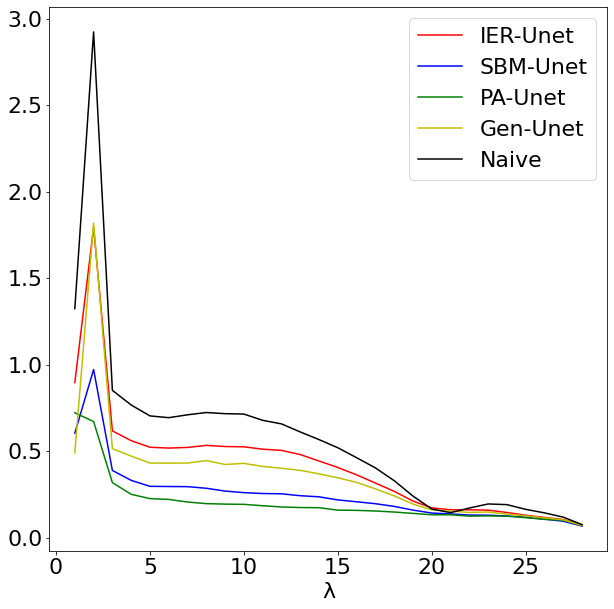

In [ ]:
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = [10, 10]
k = np.arange(1, len(ERUnet_specdiff_sb[0])+1,1)
plt.plot(k, ERUnet_avg_diff_sb,'r') 
plt.plot(k, SBMUnet_avg_diff_sb,'b') 
plt.plot(k, PAUnet_avg_diff_sb,'g') 
plt.plot(k, GenUnet_avg_diff_sb,'y') 
plt.plot(k, baseline_avg_diff_sb,'k') 
plt.legend(["IER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Naive"])
#plt.title('Average Absolute Difference per Eigenvalue - SBM Testing Data')
plt.xlabel(chr(955))
plt.savefig('SBM-AADE.pdf')

In [ ]:
import pandas as pd

In [ ]:
temp = list(zip(k, ERUnet_avg_diff_sb, SBMUnet_avg_diff_sb, PAUnet_avg_diff_sb, GenUnet_avg_diff_sb, baseline_avg_diff_sb))
colnames = [chr(955), 'ER-Unet', 'SBM-Unet', 'PA-Unet', 'Gen-Unet', 'Baseline']
AvgAbsLoss = pd.DataFrame(temp, columns = colnames)

In [ ]:
for col in AvgAbsLoss.columns:
  print(col)
  print(max(AvgAbsLoss[col]))
  print(AvgAbsLoss[col].idxmax()+1)
  print("-------------------")

λ
28
28
-------------------
ER-Unet
1.7942906122626032
2
-------------------
SBM-Unet
0.9723650049701257
2
-------------------
PA-Unet
0.7223235255720879
1
-------------------
Gen-Unet
1.8194295273438512
2
-------------------
Baseline
2.925509367652484
2
-------------------


In [ ]:
for col in AvgAbsLoss.columns:
  print(col)
  print(min(AvgAbsLoss[col]))
  print(AvgAbsLoss[col].idxmin()+1)
  print("-------------------")

λ
1
1
-------------------
ER-Unet
0.07343729468253679
28
-------------------
SBM-Unet
0.06670108155186434
28
-------------------
PA-Unet
0.06980673064508373
28
-------------------
Gen-Unet
0.07004204762716451
28
-------------------
Baseline
0.07504061472952278
28
-------------------


In [ ]:
AvgAbsLoss

,λ,ER-Unet,SBM-Unet,PA-Unet,Gen-Unet,Baseline
0,1,0.896840,0.604078,0.722324,0.490131,1.324277
1,2,1.794291,0.972365,0.671492,1.819430,2.925509
2,3,0.617413,0.388563,0.318151,0.514770,0.852033
3,4,0.560840,0.331311,0.250542,0.471530,0.767288
4,5,0.522810,0.296628,0.225764,0.431262,0.704153
5,6,0.518018,0.295706,0.221027,0.430954,0.693863
6,7,0.521771,0.294759,0.205874,0.431379,0.710476
7,8,0.533467,0.285521,0.196549,0.445640,0.723772
8,9,0.526986,0.269180,0.193897,0.423177,0.717019
9,10,0.525243,0.260279,0.192517,0.429534,0.714693


#### Relative Loss

Text(0.5, 0, 'λ')

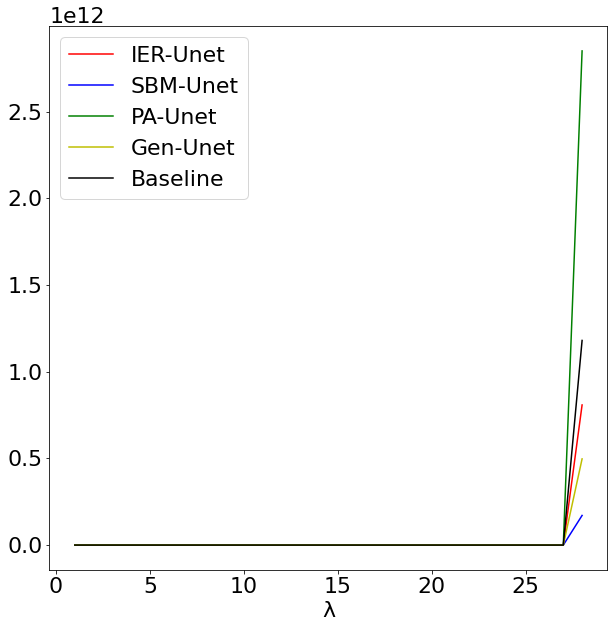

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
k = np.arange(1, len(ERUnet_percent_specdiff_sb[0])+1,1)
plt.plot(k, ERUnet_avg_percent_diff_sb,'r') 
plt.plot(k, SBMUnet_avg_percent_diff_sb,'b') 
plt.plot(k, PAUnet_avg_percent_diff_sb,'g') 
plt.plot(k, GenUnet_avg_percent_diff_sb,'y') 
plt.plot(k, baseline_avg_percent_diff_sb,'k') 
plt.legend(["IER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Baseline"])
#plt.title('Average Absolute Percent Difference per Eigenvalue - SBM Testing Data')
plt.xlabel(chr(955))

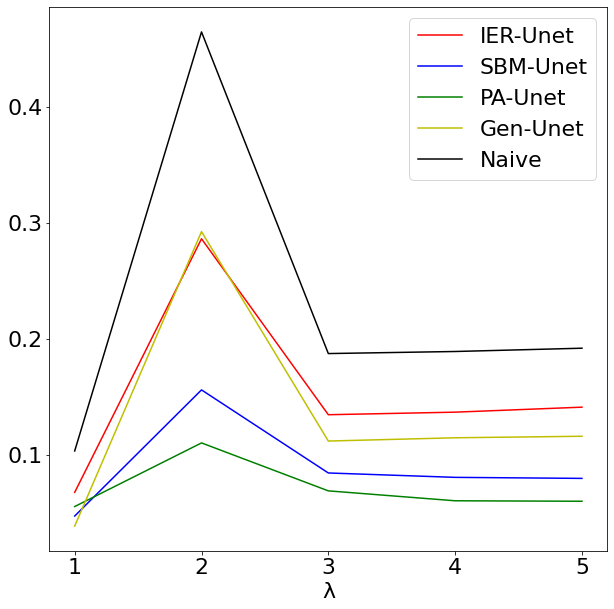

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
k = np.arange(1, len(ERUnet_percent_specdiff_sb[0])+1,1)
plt.plot(k[0:5], ERUnet_avg_percent_diff_sb[0:5],'r') 
plt.plot(k[0:5], SBMUnet_avg_percent_diff_sb[0:5],'b') 
plt.plot(k[0:5], PAUnet_avg_percent_diff_sb[0:5],'g') 
plt.plot(k[0:5], GenUnet_avg_percent_diff_sb[0:5],'y') 
plt.plot(k[0:5], baseline_avg_percent_diff_sb[0:5],'k') 
plt.legend(["IER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Naive"])
#plt.title('Average Absolute Percent Difference per Eigenvalue - SBM Testing Data')
plt.xlabel(chr(955))
plt.savefig('SBM-AAPDE.pdf')

In [ ]:
temp = list(zip(k, ERUnet_avg_percent_diff_sb, SBMUnet_avg_percent_diff_sb, 
                PAUnet_avg_percent_diff_sb, GenUnet_avg_percent_diff_sb, baseline_avg_percent_diff_sb))
colnames = [chr(955), 'ER-Unet', 'SBM-Unet', 'PA-Unet', 'Gen-Unet', 'Baseline']
AvgPctLoss = pd.DataFrame(temp, columns = colnames)

In [ ]:
for col in AvgPctLoss.columns:
  print(col)
  print(max(AvgPctLoss[col]))
  print(AvgPctLoss[col].idxmax()+1)
  print("-------------------")

λ
28
28
-------------------
ER-Unet
808323681950.9246
28
-------------------
SBM-Unet
171004222315.02856
28
-------------------
PA-Unet
2850403364375.654
28
-------------------
Gen-Unet
497216483107.1504
28
-------------------
Baseline
1180366545942.2512
28
-------------------


In [ ]:
for col in AvgPctLoss.columns:
  print(col)
  print(min(AvgPctLoss[col]))
  print(AvgPctLoss[col].idxmin()+1)
  print("-------------------")

λ
1
1
-------------------
ER-Unet
0.06732288126890187
1
-------------------
SBM-Unet
0.046874276984180174
1
-------------------
PA-Unet
0.055066586048413566
1
-------------------
Gen-Unet
0.038192956257714954
1
-------------------
Baseline
0.10306328205400007
1
-------------------


In [ ]:
AvgPctLoss

,λ,ER-Unet,SBM-Unet,PA-Unet,Gen-Unet,Baseline
0,1,6.732288e-02,4.687428e-02,5.506659e-02,3.819296e-02,1.030633e-01
1,2,2.862776e-01,1.557871e-01,1.100087e-01,2.924176e-01,4.648683e-01
2,3,1.343541e-01,8.405516e-02,6.860491e-02,1.116214e-01,1.871537e-01
3,4,1.365594e-01,8.026705e-02,6.004350e-02,1.144437e-01,1.889384e-01
4,5,1.408723e-01,7.937759e-02,5.963600e-02,1.157581e-01,1.917772e-01
5,6,1.515264e-01,8.556397e-02,6.305623e-02,1.251454e-01,2.049151e-01
6,7,1.635388e-01,9.142781e-02,6.283533e-02,1.342537e-01,2.249828e-01
7,8,1.777510e-01,9.451746e-02,6.409737e-02,1.480115e-01,2.436825e-01
8,9,1.880400e-01,9.545221e-02,6.766546e-02,1.505435e-01,2.585077e-01
9,10,1.996166e-01,9.812469e-02,7.153152e-02,1.623383e-01,2.740020e-01


#### Graphs

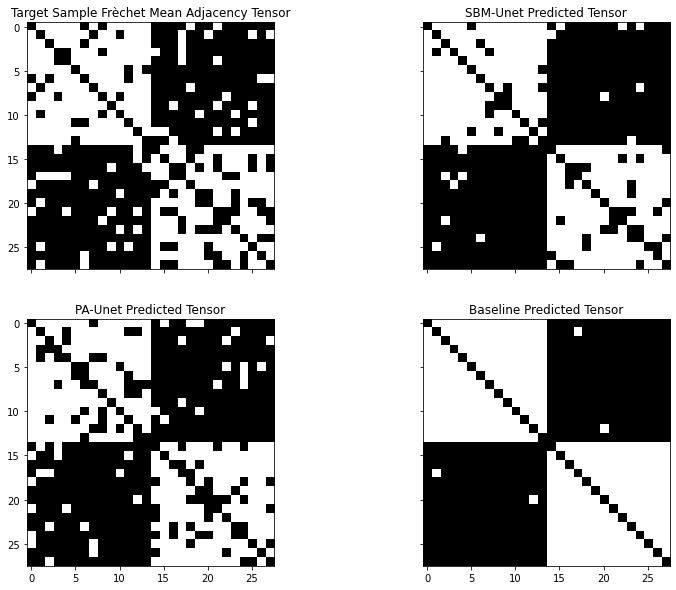

In [ ]:
plt.rcParams['figure.figsize'] = [13, 10]
fig, axs = plt.subplots(2, 2)

axs[0,0].imshow(y_test_sb[3].reshape((28,28)), cmap=plt.get_cmap('gray'))
axs[0,0].set_title('Target Sample Frèchet Mean Adjacency Tensor')

axs[0,1].imshow(SBMUnet_pred_sb[3].reshape((28,28)), cmap=plt.get_cmap('gray'))
axs[0,1].set_title('SBM-Unet Predicted Tensor')

axs[1,0].imshow(PAUnet_pred_sb[3].reshape((28,28)), cmap=plt.get_cmap('gray'))
axs[1,0].set_title('PA-Unet Predicted Tensor')

axs[1,1].imshow(baseline_pred_sb[3].reshape((28,28)), cmap=plt.get_cmap('gray'))
axs[1,1].set_title('Baseline Predicted Tensor')

for ax in axs.flat:
  ax.label_outer()

Text(0.5, 0, 'λ')

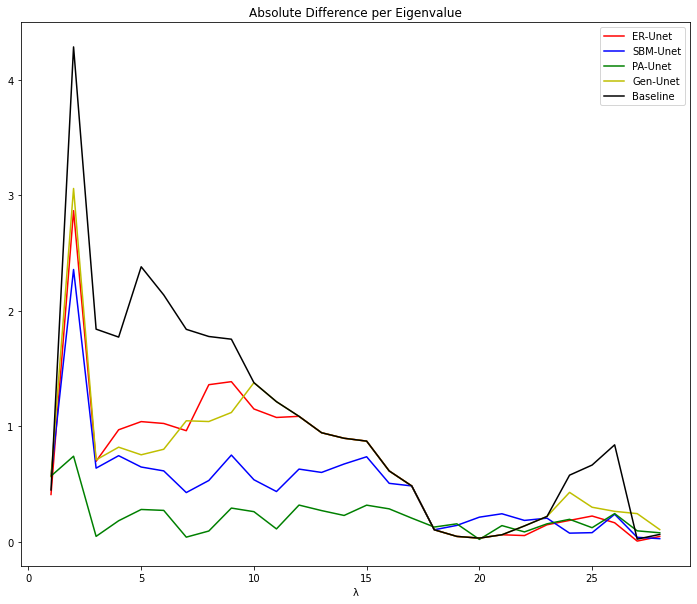

In [ ]:
plt.rcParams['figure.figsize'] = [12, 10]
k = np.arange(1, len(ERUnet_specdiff_sb[0])+1,1)
plt.plot(k, ERUnet_specdiff_sb[3],'r') 
plt.plot(k, SBMUnet_specdiff_sb[3],'b') 
plt.plot(k, PAUnet_specdiff_sb[3],'g') 
plt.plot(k, GenUnet_specdiff_sb[3],'y') 
plt.plot(k, baseline_specdiff_sb[3],'k') 
plt.legend(["ER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Baseline"])
plt.title('Absolute Difference per Eigenvalue')
plt.xlabel(chr(955))

Text(0.5, 0, 'λ')

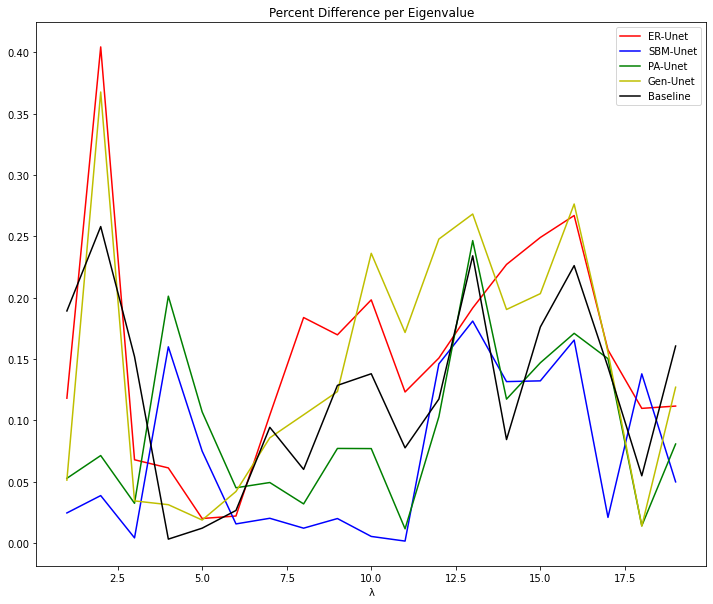

In [ ]:
plt.rcParams['figure.figsize'] = [12, 10]
k = np.arange(1, len(ERUnet_specdiff_sb[0])+1,1)
plt.plot(k[0:19], ERUnet_percent_specdiff_sb[200][0:19],'r') 
plt.plot(k[0:19], SBMUnet_percent_specdiff_sb[200][0:19],'b') 
plt.plot(k[0:19], PAUnet_percent_specdiff_sb[200][0:19],'g') 
plt.plot(k[0:19], GenUnet_percent_specdiff_sb[200][0:19],'y') 
plt.plot(k[0:19], baseline_percent_specdiff_sb[200][0:19],'k') 
plt.legend(["ER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Baseline"])
plt.title('Percent Difference per Eigenvalue')
plt.xlabel(chr(955))

### Sample Mean Spectra Comparision 

In [ ]:
len(sample_mean_spectra_sb)

900

In [ ]:
ERUNet_Sms_diff_sb = Testing.spectral_diff(ERUnet_eigenvals_sb, sample_mean_spectra_sb)
SBMUNet_Sms_diff_sb = Testing.spectral_diff(SBMUnet_eigenvals_sb, sample_mean_spectra_sb)
PAUNet_Sms_diff_sb = Testing.spectral_diff(PAUnet_eigenvals_sb, sample_mean_spectra_sb)
GenUNet_Sms_diff_sb = Testing.spectral_diff(GenUnet_eigenvals_sb, sample_mean_spectra_sb)

baseline_Sms_diff_sb = Testing.spectral_diff(baseline_eigenvals_sb, sample_mean_spectra_sb)

ERUNet_Sms_perdiff_sb = Testing.spectral_diff(ERUnet_eigenvals_sb, sample_mean_spectra_sb, percent=True)
SBMUNet_Sms_perdiff_sb = Testing.spectral_diff(SBMUnet_eigenvals_sb, sample_mean_spectra_sb, percent=True)
PAUNet_Sms_perdiff_sb = Testing.spectral_diff(PAUnet_eigenvals_sb, sample_mean_spectra_sb, percent=True)
GenUNet_Sms_perdiff_sb = Testing.spectral_diff(GenUnet_eigenvals_sb, sample_mean_spectra_sb, percent=True)

baseline_Sms_perdiff_sb = Testing.spectral_diff(baseline_eigenvals_sb, sample_mean_spectra_sb, percent=True)

In [ ]:
ERUNet_AvgSms_diff_sb = Testing.average_spectral_diff(ERUNet_Sms_diff_sb)
SBMUNet_AvgSms_diff_sb = Testing.average_spectral_diff(SBMUNet_Sms_diff_sb)
PAUNet_AvgSms_diff_sb = Testing.average_spectral_diff(PAUNet_Sms_diff_sb)
GenUNet_AvgSms_diff_sb = Testing.average_spectral_diff(GenUNet_Sms_diff_sb)

baseline_AvgSms_diff_sb = Testing.average_spectral_diff(baseline_Sms_diff_sb)

ERUNet_AvgSms_perdiff_sb = Testing.average_spectral_diff(ERUNet_Sms_perdiff_sb)
SBMUNet_AvgSms_perdiff_sb = Testing.average_spectral_diff(SBMUNet_Sms_perdiff_sb)
PAUNet_AvgSms_perdiff_sb = Testing.average_spectral_diff(PAUNet_Sms_perdiff_sb)
GenUNet_AvgSms_perdiff_sb = Testing.average_spectral_diff(GenUNet_Sms_perdiff_sb)

baseline_AvgSms_perdiff_sb = Testing.average_spectral_diff(baseline_Sms_perdiff_sb)

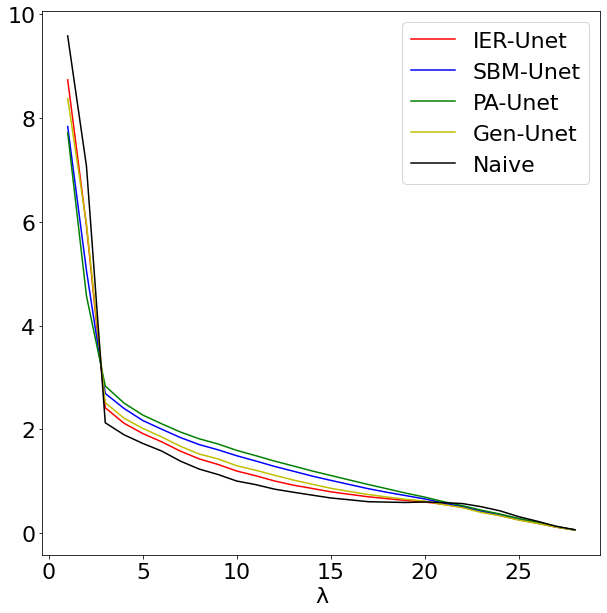

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
k = np.arange(1, len(ERUNet_AvgSms_diff_sb)+1,1)
plt.plot(k, ERUNet_AvgSms_diff_sb,'r') 
plt.plot(k, SBMUNet_AvgSms_diff_sb,'b') 
plt.plot(k, PAUNet_AvgSms_diff_sb,'g') 
plt.plot(k, GenUNet_AvgSms_diff_sb,'y') 
plt.plot(k, baseline_AvgSms_diff_sb,'k') 

plt.legend(["IER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Naive"])
#plt.title('Average Absolute Difference per Eigenvalue Between Sample Mean Spectrum & Predicted - SBM Testing Data')
plt.xlabel(chr(955))
plt.savefig('SBM-AVG-SMS.pdf')

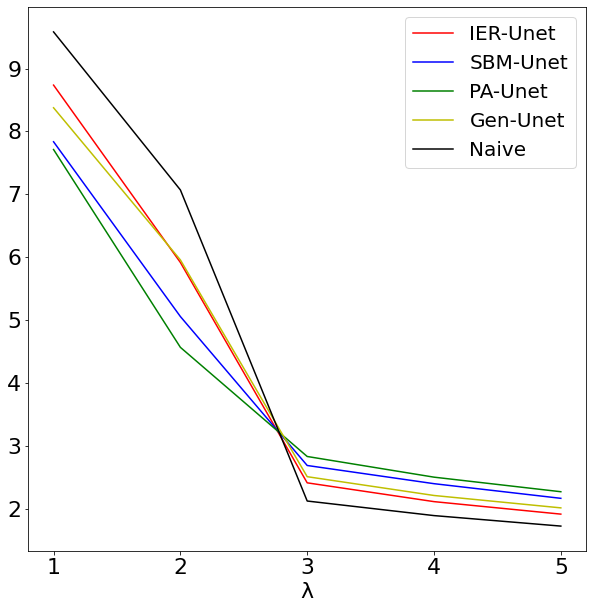

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
k = [1,2,3,4,5]
plt.xticks(k)
plt.plot(k[0:5], ERUNet_AvgSms_diff_sb[0:5],'r') 
plt.plot(k[0:5], SBMUNet_AvgSms_diff_sb[0:5],'b') 
plt.plot(k[0:5], PAUNet_AvgSms_diff_sb[0:5],'g') 
plt.plot(k[0:5], GenUNet_AvgSms_diff_sb[0:5],'y') 
plt.plot(k[0:5], baseline_AvgSms_diff_sb[0:5],'k') 

plt.legend(["IER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Naive"], prop={'size': 20})
#plt.title('Average Absolute Difference per Eigenvalue Between Sample Mean Spectrum & Predicted - SBM Testing Data')
plt.xlabel(chr(955))
plt.savefig('SBM-AVG-SMS-PCT.pdf')

Text(0.5, 0, 'λ')

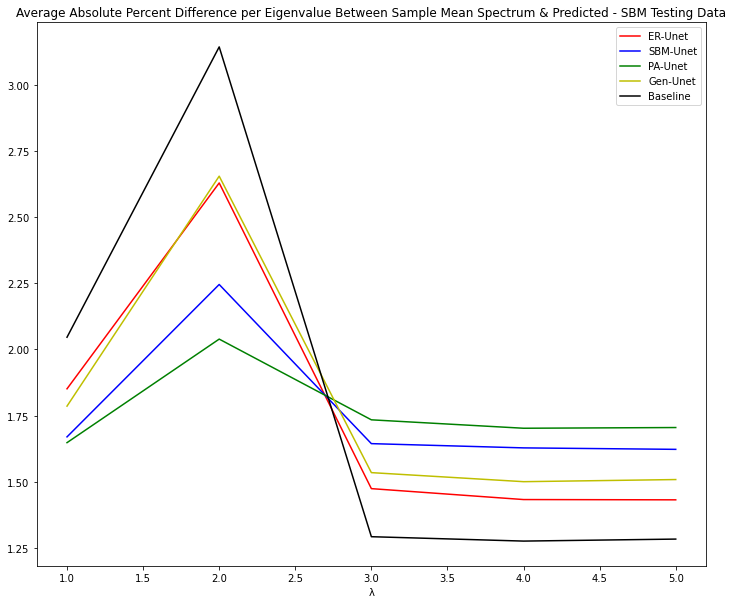

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
k = np.arange(1, len(ERUNet_AvgSms_perdiff_sb)+1,1)
plt.plot(k[0:5], ERUNet_AvgSms_perdiff_sb[0:5],'r') 
plt.plot(k[0:5], SBMUNet_AvgSms_perdiff_sb[0:5],'b') 
plt.plot(k[0:5], PAUNet_AvgSms_perdiff_sb[0:5],'g') 
plt.plot(k[0:5], GenUNet_AvgSms_perdiff_sb[0:5],'y') 
plt.plot(k[0:5], baseline_AvgSms_perdiff_sb[0:5],'k') 

plt.legend(["ER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Baseline", "Target"])
plt.title('Average Absolute Percent Difference per Eigenvalue Between Sample Mean Spectrum & Predicted - SBM Testing Data')
plt.xlabel(chr(955))

### Degree Distributions 

In [ ]:
ytest_degree, ytest_cnt, ytest_pk = Testing.degree_dist(y_test_sb)
ERUnet_pred_degree, ERUnet_pred_cnt, ERUnet_pred_pk = Testing.degree_dist(ERUnet_pred_sb)
GenUnet_pred_degree, GenUnet_pred_cnt, GenUnet_pred_pk = Testing.degree_dist(GenUnet_pred_sb)
SBMUnet_pred_degree, SBMUnet_pred_cnt, SBM_pred_pk = Testing.degree_dist(SBMUnet_pred_sb)
PAUnet_pred_degree, PAUnet_pred_cnt, PAUnet_pred_pk = Testing.degree_dist(PAUnet_pred_sb)
baseline_pred_degree, baseline_pred_cnt, baseline_pred_pk = Testing.degree_dist(baseline_pred_sb, reshape=False, round=False)

In [ ]:
ER_AdKL, ER_targetCounts, ER_predCounts, ER_degrees = Testing.AdjustedKL(ytest_degree, ytest_cnt, ERUnet_pred_degree, ERUnet_pred_cnt)
Gen_AdKL, Gen_targetCounts, Gen_predCounts, Gen_degrees = Testing.AdjustedKL(ytest_degree, ytest_cnt, GenUnet_pred_degree, GenUnet_pred_cnt)
SBM_AdKL, SBM_targetCounts, SBM_predCounts, SBM_degrees = Testing.AdjustedKL(ytest_degree, ytest_cnt, SBMUnet_pred_degree, SBMUnet_pred_cnt)
PA_AdKL, PA_targetCounts, PA_predCounts, PA_degrees = Testing.AdjustedKL(ytest_degree, ytest_cnt, PAUnet_pred_degree, PAUnet_pred_cnt)
baseline_AdKL, baseline_targetCounts, baseline_predCounts, baseline_degrees = Testing.AdjustedKL(ytest_degree, ytest_cnt, baseline_pred_degree, baseline_pred_cnt)

In [ ]:
print(round(np.mean(ER_AdKL),5))
print(round(np.mean(SBM_AdKL),5)) 
print(round(np.mean(PA_AdKL),5)) 
print(round(np.mean(Gen_AdKL),5)) 
print(round(np.mean(baseline_AdKL), 5))

0.50344
0.43466
0.59956
0.36839
0.43343


In [ ]:
print(round(np.var(ER_AdKL),5))
print(round(np.var(SBM_AdKL),5)) 
print(round(np.var(PA_AdKL),5)) 
print(round(np.var(Gen_AdKL),5)) 
print(round(np.var(baseline_AdKL),5))

0.09109
0.0419
0.0488
0.02435
0.0476


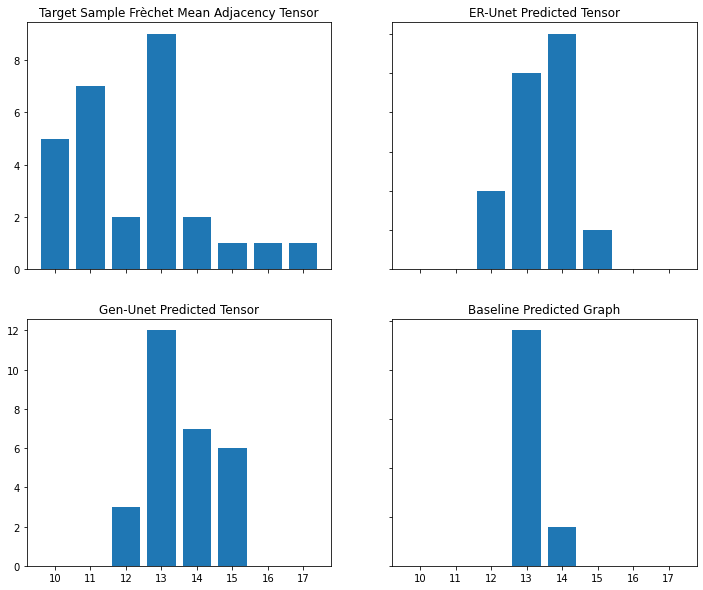

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 10]
fig, axs = plt.subplots(2, 2)

axs[0,0].bar(ytest_degree[3], ytest_cnt[3])
axs[0,0].set_title('Target Sample Frèchet Mean Adjacency Tensor')

axs[0,1].bar(ER_degrees[3], ER_predCounts[3])
axs[0,1].set_title('ER-Unet Predicted Tensor')

axs[1,0].bar(Gen_degrees[3], Gen_predCounts[3])
axs[1,0].set_title('Gen-Unet Predicted Tensor')

axs[1,1].bar(baseline_degrees[3], baseline_predCounts[3])
axs[1,1].set_title('Baseline Predicted Graph')

for ax in axs.flat:
  ax.label_outer()

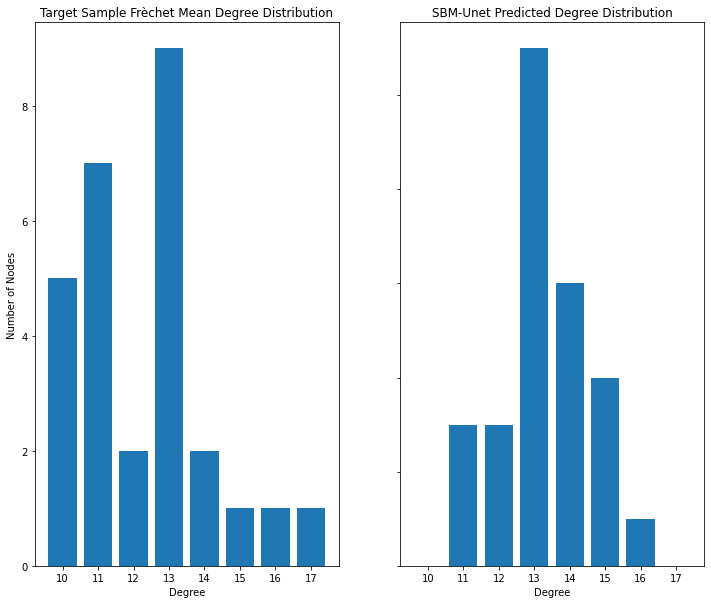

In [ ]:
plt.rcParams['figure.figsize'] = [12, 10]
fig, axs = plt.subplots(1, 2)

axs[0].bar(ytest_degree[3], ytest_cnt[3])
axs[0].set_title('Target Sample Frèchet Mean Degree Distribution')
axs[0].set_ylabel('Number of Nodes')
axs[0].set_xlabel('Degree')

axs[1].bar(SBM_degrees[3], SBM_predCounts[3])
axs[1].set_title('SBM-Unet Predicted Degree Distribution')
axs[1].set_ylabel('Number of Nodes')
axs[1].set_xlabel('Degree')

for ax in axs.flat:
  ax.label_outer()

In [ ]:
kl = Testing.AdKL(ytest_cnt[3], SBM_predCounts[3])

In [ ]:
print(kl)

0.37933184967010614


## Testing on Pref Attachment Data 

### Loading the Data, Predicting, and Generating the Spectrum Info 

In [ ]:
ERUnet_pred_pref = ERUnet.predict(x_test_pref)
ERUnet_pred_pref = ERUnet_pred_pref.round(decimals=0)
SBMUnet_pred_pref = SBMUnet.predict(x_test_pref)
SBMUnet_pred_pref = SBMUnet_pred_pref.round(decimals=0)
PAUnet_pred_pref = PAUnet.predict(x_test_pref)
PAUnet_pred_pref = PAUnet_pred_pref.round(decimals=0)
GenUnet_pred_pref = GenUnet.predict(x_test_pref)
GenUnet_pred_pref = GenUnet_pred_pref.round(decimals=0)

baseline_pred_pref = Testing.baseline_model(x_test_pref)

In [ ]:
# computing the models:
ERUnet_eigenvals_pref = Testing.spectrum(ERUnet_pred_pref)
SBMUnet_eigenvals_pref = Testing.spectrum(SBMUnet_pred_pref)
PAUnet_eigenvals_pref = Testing.spectrum(PAUnet_pred_pref)
GenUnet_eigenvals_pref = Testing.spectrum(GenUnet_pred_pref)

# baseline 
baseline_eigenvals_pref = Testing.spectrum(baseline_pred_pref, reshape=False, round=False)

#target 
target_eigenvals_pref = Testing.spectrum(y_test_pref)

In [ ]:
ERUnet_specdiff_pref = Testing.spectral_diff(ERUnet_eigenvals_pref, target_eigenvals_pref)
SBMUnet_specdiff_pref = Testing.spectral_diff(SBMUnet_eigenvals_pref, target_eigenvals_pref)
PAUnet_specdiff_pref = Testing.spectral_diff(PAUnet_eigenvals_pref, target_eigenvals_pref)
GenUnet_specdiff_pref = Testing.spectral_diff(GenUnet_eigenvals_pref, target_eigenvals_pref)

baseline_specdiff_pref = Testing.spectral_diff(baseline_eigenvals_pref, target_eigenvals_pref)

ERUnet_percent_specdiff_pref = Testing.spectral_diff(ERUnet_eigenvals_pref, target_eigenvals_pref, percent=True)
SBMUnet_percent_specdiff_pref = Testing.spectral_diff(SBMUnet_eigenvals_pref, target_eigenvals_pref, percent=True)
PAUnet_percent_specdiff_pref = Testing.spectral_diff(PAUnet_eigenvals_pref, target_eigenvals_pref, percent=True)
GenUnet_percent_specdiff_pref = Testing.spectral_diff(GenUnet_eigenvals_pref, target_eigenvals_pref, percent=True)

baseline_percent_specdiff_pref = Testing.spectral_diff(baseline_eigenvals_pref, target_eigenvals_pref, percent=True)

In [ ]:
ERUnet_avg_diff_pref = Testing.average_spectral_diff(ERUnet_specdiff_pref)
SBMUnet_avg_diff_pref = Testing.average_spectral_diff(SBMUnet_specdiff_pref)
PAUnet_avg_diff_pref = Testing.average_spectral_diff(PAUnet_specdiff_pref)
GenUnet_avg_diff_pref = Testing.average_spectral_diff(GenUnet_specdiff_pref)

baseline_avg_diff_pref = Testing.average_spectral_diff(baseline_specdiff_pref)

ERUnet_avg_percent_diff_pref = Testing.average_spectral_diff(ERUnet_percent_specdiff_pref)
SBMUnet_avg_percent_diff_pref = Testing.average_spectral_diff(SBMUnet_percent_specdiff_pref)
PAUnet_avg_percent_diff_pref = Testing.average_spectral_diff(PAUnet_percent_specdiff_pref)
GenUnet_avg_percent_diff_pref = Testing.average_spectral_diff(GenUnet_percent_specdiff_pref)

baseline_avg_percent_diff_pref = Testing.average_spectral_diff(baseline_percent_specdiff_pref)

### Plotting on PA Data

#### Absolute Loss

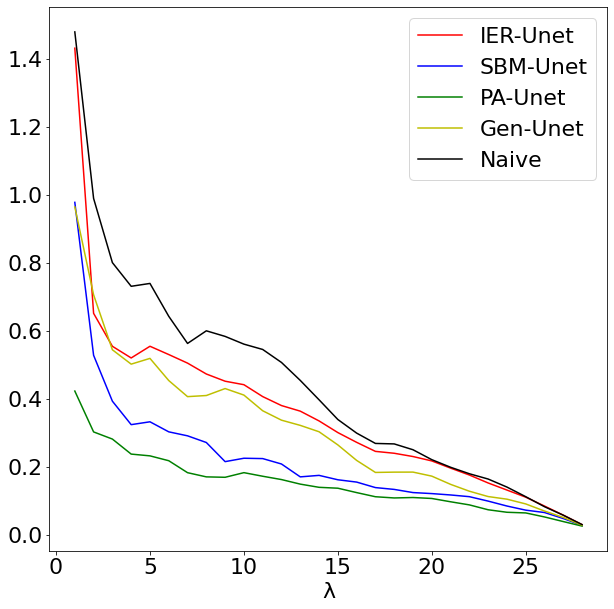

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
k = np.arange(1, len(ERUnet_specdiff_pref[0])+1,1)
plt.plot(k, ERUnet_avg_diff_pref,'r') 
plt.plot(k, SBMUnet_avg_diff_pref,'b') 
plt.plot(k, PAUnet_avg_diff_pref,'g') 
plt.plot(k, GenUnet_avg_diff_pref,'y') 
plt.plot(k, baseline_avg_diff_pref,'k') 
plt.legend(["IER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Naive"])
#plt.title('Average Absolute Difference per Eigenvalue - PA Testing Data')
plt.xlabel(chr(955))
plt.savefig('PA-AADE.pdf')

In [ ]:
import pandas as pd

In [ ]:
temp = list(zip(k, ERUnet_avg_diff_pref, SBMUnet_avg_diff_pref, PAUnet_avg_diff_pref, GenUnet_avg_diff_pref, baseline_avg_diff_pref))
colnames = [chr(955), 'ER-Unet', 'SBM-Unet', 'PA-Unet', 'Gen-Unet', 'Baseline']
AvgAbsLoss = pd.DataFrame(temp, columns = colnames)

In [ ]:
for col in AvgAbsLoss.columns:
  print(col)
  print(max(AvgAbsLoss[col]))
  print(AvgAbsLoss[col].idxmax()+1)
  print("-------------------")

λ
28
28
-------------------
ER-Unet
1.4326449489262079
1
-------------------
SBM-Unet
0.9787704415891783
1
-------------------
PA-Unet
0.4232720551988159
1
-------------------
Gen-Unet
0.9653866512399226
1
-------------------
Baseline
1.480529584078641
1
-------------------


In [ ]:
for col in AvgAbsLoss.columns:
  print(col)
  print(min(AvgAbsLoss[col]))
  print(AvgAbsLoss[col].idxmin()+1)
  print("-------------------")

λ
1
1
-------------------
ER-Unet
0.029957144314812476
28
-------------------
SBM-Unet
0.027803634868188945
28
-------------------
PA-Unet
0.02574474813437565
28
-------------------
Gen-Unet
0.02839231391030065
28
-------------------
Baseline
0.03014305730025704
28
-------------------


In [ ]:
AvgAbsLoss

,λ,ER-Unet,SBM-Unet,PA-Unet,Gen-Unet,Baseline
0,1,1.432645,0.978770,0.423272,0.965387,1.480530
1,2,0.652035,0.528490,0.302969,0.706567,0.990286
2,3,0.555033,0.393454,0.281935,0.544765,0.801364
3,4,0.520697,0.324387,0.237694,0.502501,0.731638
4,5,0.555129,0.332767,0.232495,0.519416,0.740083
5,6,0.530747,0.303204,0.218185,0.454219,0.643322
6,7,0.505515,0.291461,0.182972,0.406832,0.563420
7,8,0.473480,0.271825,0.170638,0.410127,0.600597
8,9,0.452259,0.215493,0.169404,0.430619,0.584165
9,10,0.441972,0.225470,0.183048,0.411414,0.561394


#### Relative Loss

Text(0.5, 0, 'λ')

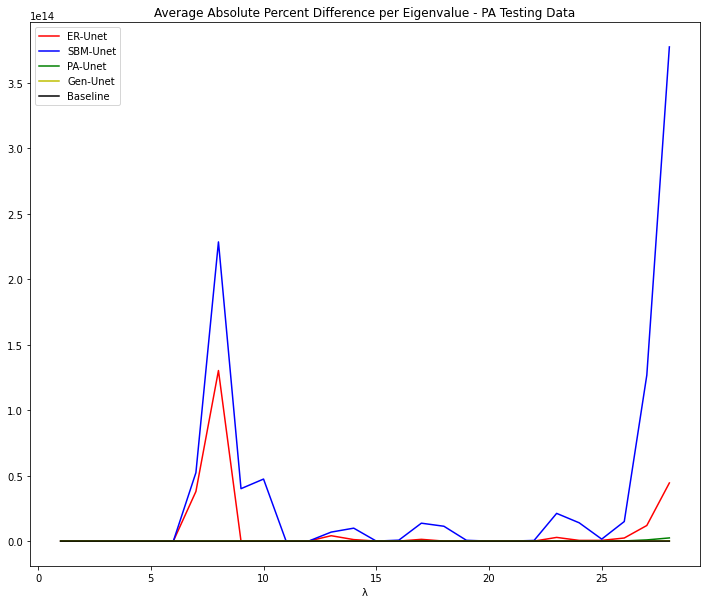

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
k = np.arange(1, len(ERUnet_percent_specdiff_pref[0])+1,1)
plt.plot(k, ERUnet_avg_percent_diff_pref,'r') 
plt.plot(k, SBMUnet_avg_percent_diff_pref,'b') 
plt.plot(k, PAUnet_avg_percent_diff_pref,'g') 
plt.plot(k, GenUnet_avg_percent_diff_pref,'y') 
plt.plot(k, baseline_avg_percent_diff_pref,'k') 
plt.legend(["ER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Baseline"])
plt.title('Average Absolute Percent Difference per Eigenvalue - PA Testing Data')
plt.xlabel(chr(955))

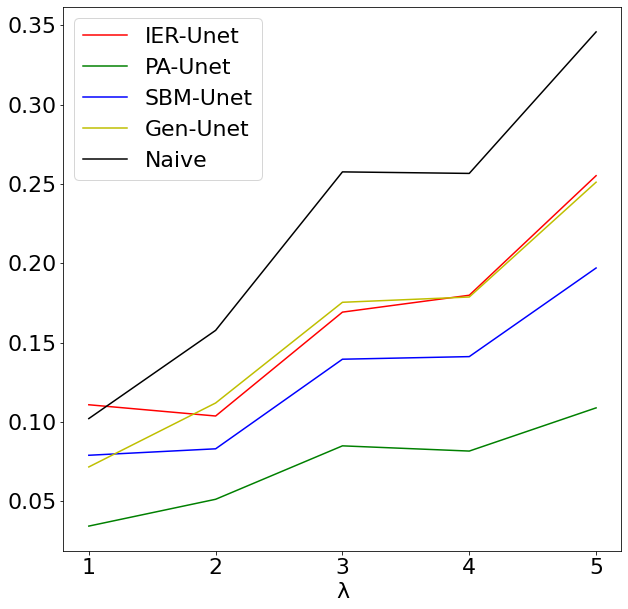

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
k = np.arange(1, len(ERUnet_percent_specdiff_pref[0])+1,1)
plt.plot(k[0:5], ERUnet_avg_percent_diff_pref[0:5],'r') 
plt.plot(k[0:5], PAUnet_avg_percent_diff_pref[0:5],'g') 
plt.plot(k[0:5], SBMUnet_avg_percent_diff_pref[0:5],'b') 
plt.plot(k[0:5], GenUnet_avg_percent_diff_pref[0:5],'y') 
plt.plot(k[0:5], baseline_avg_percent_diff_pref[0:5],'k') 
plt.legend(["IER-Unet", "PA-Unet", "SBM-Unet", "Gen-Unet", "Naive"])
#plt.title('Average Absolute Percent Difference per Eigenvalue - PA Testing Data')
plt.xlabel(chr(955))
plt.savefig('PA-AAPDE.pdf')

In [ ]:
temp = list(zip(k, ERUnet_avg_percent_diff_pref, SBMUnet_avg_percent_diff_pref, 
                PAUnet_avg_percent_diff_pref, GenUnet_avg_percent_diff_pref, baseline_avg_percent_diff_pref))
colnames = [chr(955), 'ER-Unet', 'SBM-Unet', 'PA-Unet', 'Gen-Unet', 'Baseline']
AvgPctLoss = pd.DataFrame(temp, columns = colnames)

In [ ]:
for col in AvgPctLoss.columns:
  print(col)
  print(min(AvgPctLoss[col]))
  print(AvgPctLoss[col].idxmin()+1)
  print("-------------------")

λ
1
1
-------------------
ER-Unet
0.10377903441813922
2
-------------------
SBM-Unet
0.07902544368848775
1
-------------------
PA-Unet
0.03437202935029596
1
-------------------
Gen-Unet
0.07166779159584745
1
-------------------
Baseline
0.10216197725503848
1
-------------------


In [ ]:
AvgPctLoss

,λ,ER-Unet,SBM-Unet,PA-Unet,Gen-Unet,Baseline
0,1,1.108683e-01,7.902544e-02,3.437203e-02,7.166779e-02,1.021620e-01
1,2,1.037790e-01,8.310036e-02,5.127817e-02,1.119898e-01,1.577756e-01
2,3,1.692772e-01,1.395873e-01,8.496241e-02,1.754767e-01,2.576934e-01
3,4,1.799162e-01,1.412273e-01,8.167419e-02,1.788044e-01,2.567312e-01
4,5,2.552877e-01,1.970953e-01,1.089086e-01,2.511975e-01,3.459475e-01
5,6,3.639884e-01,3.073275e-01,1.428756e-01,2.739916e-01,3.466617e-01
6,7,3.785889e+13,5.223636e+13,1.325157e-01,2.514434e-01,3.131336e-01
7,8,1.302192e+14,2.284335e+14,1.513151e-01,2.416667e-01,3.317554e-01
8,9,6.653471e-01,4.002416e+13,2.199212e-01,3.250340e-01,4.063439e-01
9,10,6.933524e-01,4.736325e+13,3.762985e-01,5.235866e-01,6.488226e-01


#### Graphs

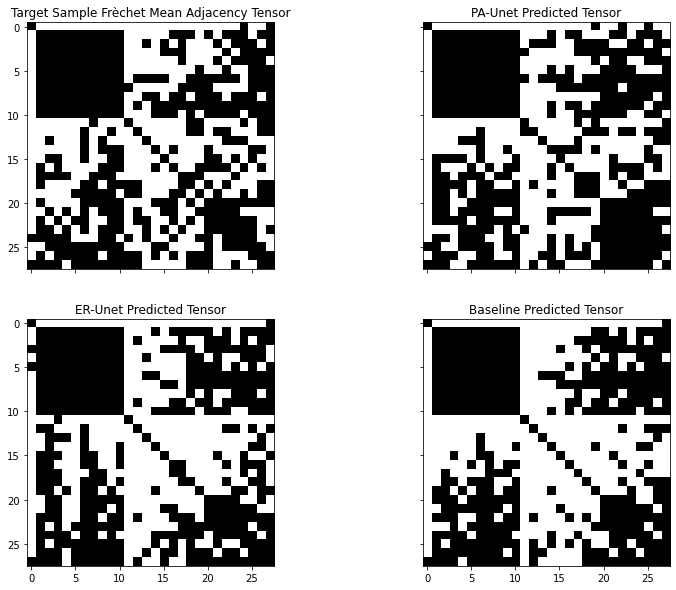

In [ ]:
plt.rcParams['figure.figsize'] = [13, 10]
fig, axs = plt.subplots(2, 2)

axs[0,0].imshow(y_test_pref[250].reshape((28,28)), cmap=plt.get_cmap('gray'))
axs[0,0].set_title('Target Sample Frèchet Mean Adjacency Tensor')

axs[0,1].imshow(PAUnet_pred_pref[250].reshape((28,28)), cmap=plt.get_cmap('gray'))
axs[0,1].set_title('PA-Unet Predicted Tensor')

axs[1,0].imshow(ERUnet_pred_pref[250].reshape((28,28)), cmap=plt.get_cmap('gray'))
axs[1,0].set_title('ER-Unet Predicted Tensor')

axs[1,1].imshow(baseline_pred_pref[250], cmap=plt.get_cmap('gray'))
axs[1,1].set_title('Baseline Predicted Tensor')

for ax in axs.flat:
  ax.label_outer()

Text(0.5, 0, 'λ')

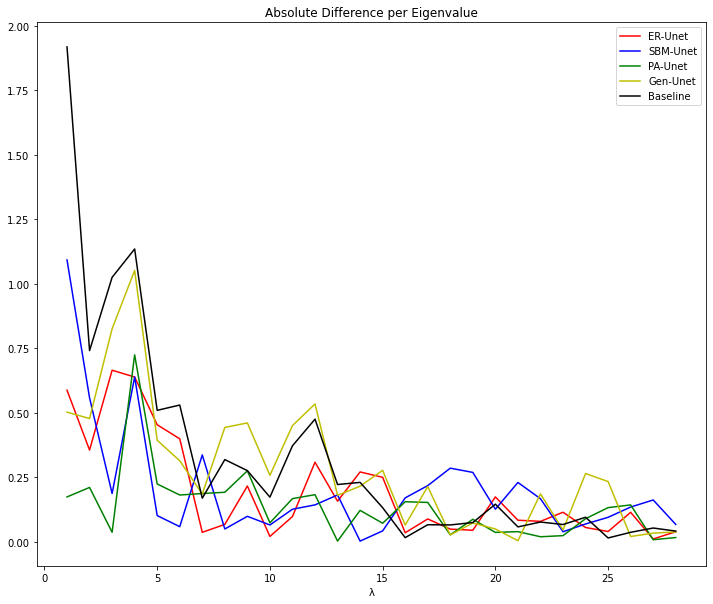

In [ ]:
plt.rcParams['figure.figsize'] = [12, 10]
k = np.arange(1, len(ERUnet_specdiff_pref[0])+1,1)
plt.plot(k, ERUnet_specdiff_pref[250],'r') 
plt.plot(k, SBMUnet_specdiff_pref[250],'b') 
plt.plot(k, PAUnet_specdiff_pref[250],'g') 
plt.plot(k, GenUnet_specdiff_pref[250],'y') 
plt.plot(k, baseline_specdiff_pref[250],'k') 
plt.legend(["ER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Baseline"])
plt.title('Absolute Difference per Eigenvalue')
plt.xlabel(chr(955))

Text(0.5, 0, 'λ')

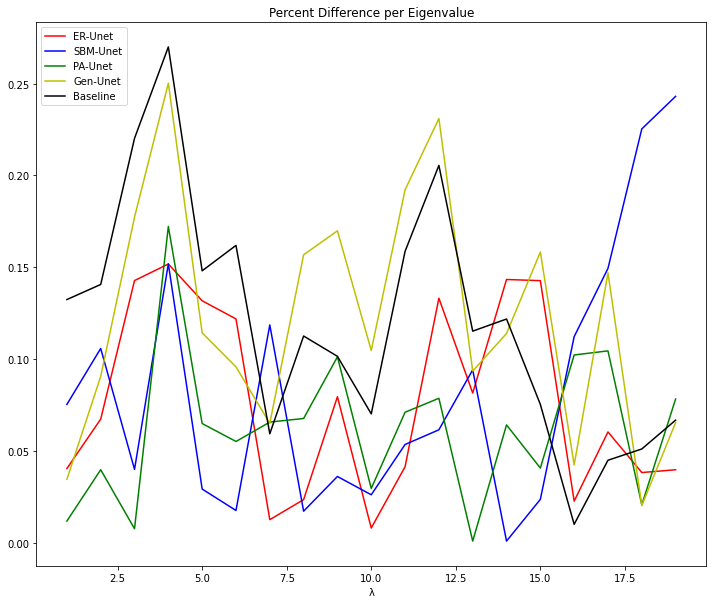

In [ ]:
plt.rcParams['figure.figsize'] = [12, 10]
k = np.arange(1, len(ERUnet_specdiff_pref[0])+1,1)
plt.plot(k[0:19], ERUnet_percent_specdiff_pref[250][0:19],'r') 
plt.plot(k[0:19], SBMUnet_percent_specdiff_pref[250][0:19],'b') 
plt.plot(k[0:19], PAUnet_percent_specdiff_pref[250][0:19],'g') 
plt.plot(k[0:19], GenUnet_percent_specdiff_pref[250][0:19],'y') 
plt.plot(k[0:19], baseline_percent_specdiff_pref[250][0:19],'k') 
plt.legend(["ER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Baseline"])
plt.title('Percent Difference per Eigenvalue')
plt.xlabel(chr(955))

### Sample Mean Spectrum

In [ ]:
len(sample_mean_spectra_pref)

900

In [ ]:
ERUNet_Sms_diff_pref = Testing.spectral_diff(ERUnet_eigenvals_pref, sample_mean_spectra_pref)
SBMUNet_Sms_diff_pref = Testing.spectral_diff(SBMUnet_eigenvals_pref, sample_mean_spectra_pref)
PAUNet_Sms_diff_pref = Testing.spectral_diff(PAUnet_eigenvals_pref, sample_mean_spectra_pref)
GenUNet_Sms_diff_pref = Testing.spectral_diff(GenUnet_eigenvals_pref, sample_mean_spectra_pref)

baseline_Sms_diff_pref = Testing.spectral_diff(baseline_eigenvals_pref, sample_mean_spectra_pref)

ERUNet_Sms_perdiff_pref = Testing.spectral_diff(ERUnet_eigenvals_pref, sample_mean_spectra_pref, percent=True)
SBMUNet_Sms_perdiff_pref = Testing.spectral_diff(SBMUnet_eigenvals_pref, sample_mean_spectra_pref, percent=True)
PAUNet_Sms_perdiff_pref = Testing.spectral_diff(PAUnet_eigenvals_pref, sample_mean_spectra_pref, percent=True)
GenUNet_Sms_perdiff_pref = Testing.spectral_diff(GenUnet_eigenvals_pref, sample_mean_spectra_pref, percent=True)

baseline_Sms_perdiff_pref = Testing.spectral_diff(baseline_eigenvals_pref, sample_mean_spectra_pref, percent=True)

In [ ]:
ERUNet_AvgSms_diff_pref = Testing.average_spectral_diff(ERUNet_Sms_diff_pref)
SBMUNet_AvgSms_diff_pref = Testing.average_spectral_diff(SBMUNet_Sms_diff_pref)
PAUNet_AvgSms_diff_pref = Testing.average_spectral_diff(PAUNet_Sms_diff_pref)
GenUNet_AvgSms_diff_pref = Testing.average_spectral_diff(GenUNet_Sms_diff_pref)

baseline_AvgSms_diff_pref = Testing.average_spectral_diff(baseline_Sms_diff_pref)

ERUNet_AvgSms_perdiff_pref = Testing.average_spectral_diff(ERUNet_Sms_perdiff_pref)
SBMUNet_AvgSms_perdiff_pref = Testing.average_spectral_diff(SBMUNet_Sms_perdiff_pref)
PAUNet_AvgSms_perdiff_pref = Testing.average_spectral_diff(PAUNet_Sms_perdiff_pref)
GenUNet_AvgSms_perdiff_pref = Testing.average_spectral_diff(GenUNet_Sms_perdiff_pref)

baseline_AvgSms_perdiff_pref = Testing.average_spectral_diff(baseline_Sms_perdiff_pref)

Text(0.5, 0, 'λ')

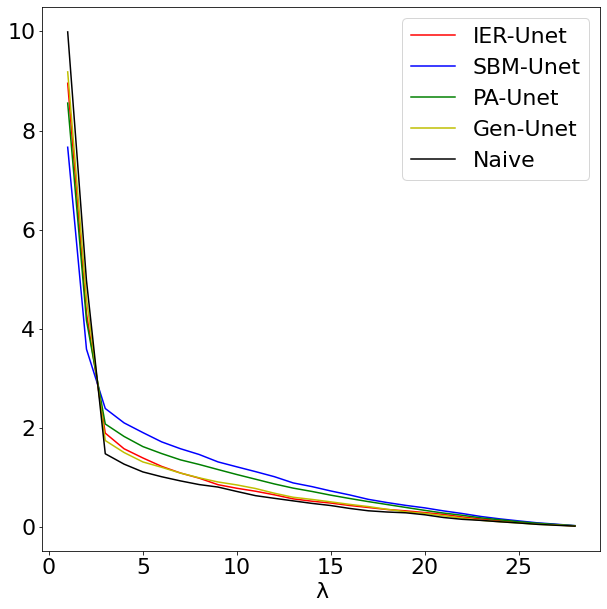

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
k = np.arange(1, len(ERUNet_AvgSms_diff_pref)+1,1)
plt.plot(k, ERUNet_AvgSms_diff_pref,'r') 
plt.plot(k, SBMUNet_AvgSms_diff_pref,'b') 
plt.plot(k, PAUNet_AvgSms_diff_pref,'g') 
plt.plot(k, GenUNet_AvgSms_diff_pref,'y') 
plt.plot(k, baseline_AvgSms_diff_pref,'k') 
plt.legend(["IER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Naive"])
#plt.title('Average Absolute Difference per Eigenvalue Between Sample Mean Spectrum & Predicted - PA Testing Data')
plt.xlabel(chr(955))

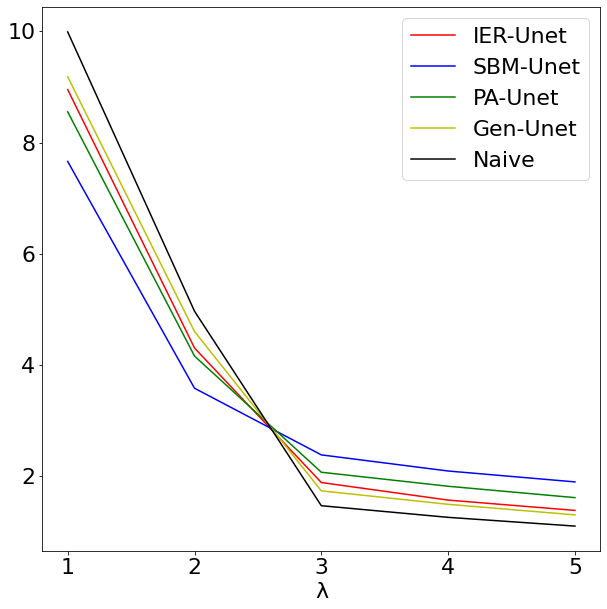

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
k = np.arange(1, len(ERUNet_AvgSms_diff_pref)+1,1)
plt.plot(k[0:5], ERUNet_AvgSms_diff_pref[0:5],'r') 
plt.plot(k[0:5], SBMUNet_AvgSms_diff_pref[0:5],'b') 
plt.plot(k[0:5], PAUNet_AvgSms_diff_pref[0:5],'g') 
plt.plot(k[0:5], GenUNet_AvgSms_diff_pref[0:5],'y') 
plt.plot(k[0:5], baseline_AvgSms_diff_pref[0:5],'k') 
plt.legend(["IER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Naive"])
#plt.title('Average Absolute Difference per Eigenvalue Between Sample Mean Spectrum & Predicted - PA Testing Data')
plt.xlabel(chr(955))
plt.savefig('PA-AVG-SMS.pdf')

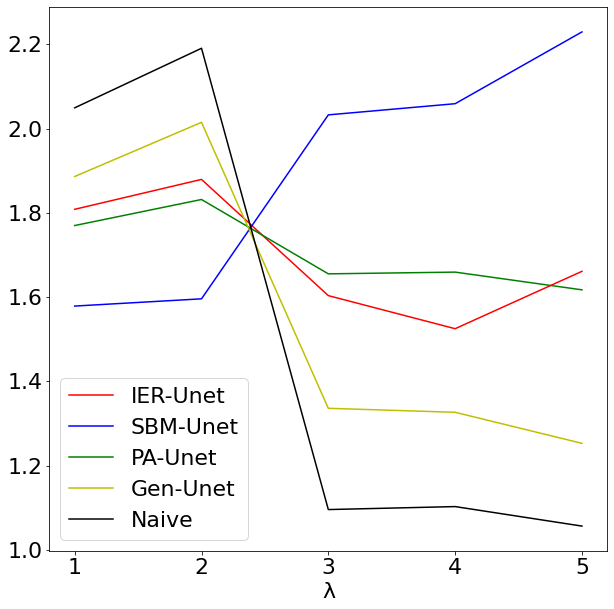

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
k = np.arange(1, len(ERUNet_AvgSms_perdiff_pref)+1,1)
plt.plot(k[0:5], ERUNet_AvgSms_perdiff_pref[0:5],'r') 
plt.plot(k[0:5], SBMUNet_AvgSms_perdiff_pref[0:5],'b') 
plt.plot(k[0:5], PAUNet_AvgSms_perdiff_pref[0:5],'g') 
plt.plot(k[0:5], GenUNet_AvgSms_perdiff_pref[0:5],'y') 
plt.plot(k[0:5], baseline_AvgSms_perdiff_pref[0:5],'k') 
plt.legend(["IER-Unet", "SBM-Unet", "PA-Unet", "Gen-Unet", "Naive"])
#plt.title('Average Absolute Percent Difference per Eigenvalue Between Sample Mean Spectrum & Predicted - PA Testing Data')
plt.xlabel(chr(955))
plt.savefig('A-AVG-SMS-PCT.pdf')

### Degree Distributions

In [ ]:
ytest_degree, ytest_cnt, ytest_pk = Testing.degree_dist(y_test_pref)
ERUnet_pred_degree, ERUnet_pred_cnt, ERUnet_pred_pk = Testing.degree_dist(ERUnet_pred_pref)
GenUnet_pred_degree, GenUnet_pred_cnt, GenUnet_pred_pk = Testing.degree_dist(GenUnet_pred_pref)
SBMUnet_pred_degree, SBMUnet_pred_cnt, SBM_pred_pk = Testing.degree_dist(SBMUnet_pred_pref)
PAUnet_pred_degree, PAUnet_pred_cnt, PAUnet_pred_pk = Testing.degree_dist(PAUnet_pred_pref)
baseline_pred_degree, baseline_pred_cnt, baseline_pred_pk = Testing.degree_dist(baseline_pred_pref, reshape=False, round=False)

In [ ]:
ER_AdKL, ER_targetCounts, ER_predCounts, ER_degrees = Testing.AdjustedKL(ytest_degree, ytest_cnt, ERUnet_pred_degree, ERUnet_pred_cnt)
Gen_AdKL, Gen_targetCounts, Gen_predCounts, Gen_degrees = Testing.AdjustedKL(ytest_degree, ytest_cnt, GenUnet_pred_degree, GenUnet_pred_cnt)
SBM_AdKL, SBM_targetCounts, SBM_predCounts, SBM_degrees = Testing.AdjustedKL(ytest_degree, ytest_cnt, SBMUnet_pred_degree, SBMUnet_pred_cnt)
PA_AdKL, PA_targetCounts, PA_predCounts, PA_degrees = Testing.AdjustedKL(ytest_degree, ytest_cnt, PAUnet_pred_degree, PAUnet_pred_cnt)
baseline_AdKL, baseline_targetCounts, baseline_predCounts, baseline_degrees = Testing.AdjustedKL(ytest_degree, ytest_cnt, baseline_pred_degree, baseline_pred_cnt)

In [ ]:
print(round(np.mean(ER_AdKL),5))
print(round(np.mean(SBM_AdKL),5)) 
print(round(np.mean(PA_AdKL),5)) 
print(round(np.mean(Gen_AdKL),5)) 
print(round(np.mean(baseline_AdKL), 5))

0.49849
0.3067
0.36472
0.42341
0.50017


In [ ]:
print(round(np.var(ER_AdKL),5))
print(round(np.var(SBM_AdKL),5)) 
print(round(np.var(PA_AdKL),5)) 
print(round(np.var(Gen_AdKL),5)) 
print(round(np.var(baseline_AdKL),5))

0.04999
0.02404
0.02348
0.02526
0.03774
